# **XGB-DQN**

### This work is based on a paper by Xin Liu and Zhonghua Gou
Their publication: Occupant-centric HVAC and window control: A reinforcement learning model for enhancing indoor thermal comfort and energy efficiency. Building and Environment (2024): 111197.

And their code serves as a basis for this notebook: https://github.com/WHU-LX/Hvac-Window-based-XGB-DQN

# S0 Preparation
### **S0** 准备工作

Before running the code, make sure to perform the following preparation steps.
- [x] Install Anaconda
- [x] Create a new environment
- [x] Install the following Python packages in the new environment: numpy, pandas, tensorflow, xgboost, scikit-learn, scikit-optimize, ...
- [x] Run Jupyter Lab in the new environment
- [x] Navigate to this file by double-clicking on it in the file directory on the left side of Jupyter Lab 
- [x] Choose the kernel of the new environment in the top right corner of Jupyter Lab



## **1** Importing Python Packages

In [1]:
#导入常用的库
import pandas as pd 
import numpy as np
from numpy import loadtxt
import random
import tensorflow as tf
import xgboost as xgb # 1.5.0
from skopt import BayesSearchCV 
from skopt.space import Integer
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

/Users/user/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-10-18 16:38:55.231066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2 Preparing Data ##

In [2]:
# 1. Read the processed CSV file, modify the file paths based on your actual file locations
# 1.读取处理后的csv文件，根据您的文件保存路径进行修改
xgb_file = "Cleaned_data.csv"
xgb_encode_file = "Cleaned_data_encode.csv"

# 2. Read the data 3. Set the timestamp format # 4. Remove missing values
# 2. 读取数据  3. 设定时间戳格式  4. 删除缺失值
data = pd.read_csv(xgb_file,encoding='gbk')
data['Date_Time'] = pd.to_datetime(data['Date_Time'])
data = data.dropna()
data = data[data != -999].dropna()
# data.head()

# 5. Encode non-numeric variables
# 5. 将非数值类型的变量进行编码 
dtypes_list=data.dtypes.values
columns_list=data.columns
for i in range(len(columns_list)):
    if dtypes_list[i]=='object':
        lb=LabelEncoder()
        lb.fit(data[columns_list[i]])
        data[columns_list[i]]=lb.transform(data[columns_list[i]])
data.head()

# data.to_csv(xgb_encode_file,index=False)

ID           Date_Time  AC_Status  Window_Status  CLast_Time  CLast_Time_T  \
0   1 2019-03-05 00:00:00          0            0.0           0             0   
1   2 2019-03-05 01:00:00          0            0.0           0             0   
2   3 2019-03-05 02:00:00          0            0.0           0             0   
3   4 2019-03-05 03:00:00          0            0.0           0             0   
4   5 2019-03-05 04:00:00          0            0.0           0             0   

   WLast_Time  WLast_Time_T  Indoor_Temp  Indoor_RH  ...  Room_ID  Study_ID  \
0         0.0           0.0        25.12      70.84  ...        0         6   
1         0.0           0.0        25.09      71.22  ...        0         6   
2         0.0           0.0        25.05      71.66  ...        0         6   
3         0.0           0.0        25.02      71.84  ...        0         6   
4         0.0           0.0        24.97      72.11  ...        0         6   

   City  Next_Indoor_Temp  Next_Indoor_RH  Next_Outdoor_Temp  Next_Outdoor_RH  \
0     0             25.09           71.22               26.0             84.0   
1     0             25.05           71.66               26.0             89.0   
2     0             25.02           71.84               26.0             89.0   
3     0             24.97           72.11               25.0             89.0   
4     0             24.92           72.12               25.0             89.0   

   Differ_Outdoor_Temp  Differ_Indoor_Temp  Target_Temp  
0                  0.0               -0.03          0.0  
1                  0.0               -0.04          0.0  
2                  0.0               -0.03          0.0  
3                 -1.0               -0.05          0.0  
4                  0.0               -0.05          0.0  

[5 rows x 27 columns]

## 3 Training the XGBoost Model

In [3]:
# 7. 'x' represents independent variables, 'y' represents the feature to be predicted
x = data.drop(['Next_Indoor_Temp','Next_Indoor_RH','Date_Time','Study_ID','Differ_Indoor_Temp','ID'],axis=1)
y = data['Differ_Indoor_Temp']

# 8. Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2022)

In [4]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
np.int = int
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.23474256920263026), ('max_depth', 5), ('n_estimators', 500)])


In [4]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
model_XGB = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.23474, 
                            n_estimators=500)
model_XGB.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.23474, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

## 3 DQN Framework

In [5]:
# Create Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# DQN
class DQN(tf.keras.Model):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_actions, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)
        
# Create Deep Q-Network (DQN) Model
def update_Q_network(batch_size, replay_buffer, Q_network, gamma, num_actions, loss_function, optimizer):
    states, actions, next_states, rewards = zip(*replay_buffer.sample(batch_size))
    states = np.array(states)
    actions = np.array(actions)
    next_states = np.array(next_states)
    rewards = np.array(rewards)

    with tf.GradientTape() as tape:
        Q_values = Q_network(states)
        target_Q_values = Q_network(next_states)
        target_Q_values = rewards + gamma * tf.reduce_max(target_Q_values, axis=1)
        mask = tf.one_hot(actions, num_actions)
        Q_action = tf.reduce_sum(tf.multiply(Q_values, mask), axis=1)
        loss = loss_function(target_Q_values, Q_action)

    grads = tape.gradient(loss, Q_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, Q_network.trainable_variables))

# Create Target Network Update Function
def update_target_network(target_network, Q_network):
    target_network.set_weights(Q_network.get_weights())

# Create ε-Greedy Policy
def epsilon_greedy_policy(state, epsilon, num_actions, Q_network):
    if np.random.rand() < epsilon:
        return np.random.randint(num_actions)
    else:
        Q_values = Q_network(np.array([state]))
        return np.argmax(Q_values)
        
# Define Reward Function
def calculate_reward(state, step, action, next_state, energy_weight=1):
    reward = 0
    standard = 'ASHRAE'
    coordinates_dict = {'ASHRAE': [[17.4, 18.4, 23.4, 24.4], [23.6, 24.6, 29.6, 30.6], [10, 30]]}
    L11, L12, U12, U11 = coordinates_dict[standard][0]
    L21, L22, U22, U21 = coordinates_dict[standard][1]
    T1, T2 = coordinates_dict[standard][2]
    InT, OutT = next_state[0], next_state[2]
    if OutT <= T1:
        L1, L2, U2, U1 = L11, L12, U12, U11
    elif OutT >= T2:
        L1, L2, U2, U1 = L21, L22, U22, U21
    else:
        increase = (OutT-T1)*(L21-L11)/(T2-T1)
        L1, L2, U2, U1 = L11+increase, L12+increase, U12+increase, U11+increase

    mid_range = (L2 + U2) / 2
    if InT>=L2 and InT<=U2:
        reward = 0
    elif InT<L2:
        reward = -60 * ((InT-mid_range) ** 2)
    elif InT>U2:
        reward = -60 * ((InT-mid_range) ** 2)
    if action==0 or action==12:
        reward = reward+0
    elif action>12:
        reward = reward-(2*(60*0.87*1)*energy_weight)
    else:
        reward = reward-((60*0.87*1)*energy_weight)
    return reward
    
# Establish Mapping between Actions and Index
def map_action_to_dataframe(action):
    Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = 0,0,0,0,0
    action = int(action)
    if action == 0:
        Target_Temp = 0
        AC_Status = 0
        CLast_Time = 0
        Window_Status = 0
        WLast_Time = 0
    elif action>0 and action<12:
        Target_Temp = 19 + action
        AC_Status = 1
        CLast_Time = 60
        Window_Status = 0
        WLast_Time = 0
    elif action == 12:
        Target_Temp = 0
        AC_Status = 0
        CLast_Time = 0
        Window_Status = 1
        WLast_Time = 60
    else:
        Target_Temp = action+7
        AC_Status = 1
        CLast_Time = 60
        Window_Status = 1
        WLast_Time = 60
    return Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time

In [6]:
# Filter Data for One Day
def choose_data(a,data):
    data_test00 = data[a:a+23]
    data_test0a = data_test00.reset_index(drop=True) # 备份
    data_test0 = data_test00.reset_index(drop=True)
    new_time_c = data_test0a.iloc[0]['CLast_Time_T'] - data_test0a.iloc[0]['AC_Status']*60
    data_test0.at[0,'CLast_Time_T'] = new_time_c
    new_time_w = data_test0a.iloc[0]['WLast_Time_T'] - data_test0a.iloc[0]['Window_Status']*60
    data_test0.at[0,'WLast_Time_T'] = new_time_w
    data_test = data_test0[['Indoor_Temp','Indoor_RH','Outdoor_Temp','Outdoor_RH','Rain','Cloud','Windspeed','Hour','Next_Outdoor_Temp','Next_Outdoor_RH']].copy()
    xgboost_test = data_test0.drop(['Next_Indoor_Temp','Next_Indoor_RH','Date_Time','Study_ID','Differ_Indoor_Temp','ID'],axis=1)
    return data_test,xgboost_test

In [10]:
data_test,xgboost_test = choose_data(0,data)    

In [12]:
state = data_test.iloc[6, :8]

In [14]:
state.head(10)

Indoor_Temp     24.88
Indoor_RH       72.26
Outdoor_Temp    25.00
Outdoor_RH      89.00
Rain             4.00
Cloud            1.00
Windspeed       90.00
Hour             6.00
Name: 6, dtype: float64

## 4 Prepare RL Data ##

In [7]:
def get_week_data_of_city(data, city, start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    city_encode_mapping = {"Florianopolis":0, "Nanjing": 1 , "Rende": 2 , "Sao Paulo": 3 }
    data['Date'] = pd.to_datetime(data['Date_Time'].dt.date)
    city_data = data[data['City'] == city_encode_mapping[city]]
    city_week_data = city_data[(city_data['Date'] >= start_date) & (city_data['Date'] <= end_date)]
    city_week_data = city_week_data.drop(columns=['Date'])
    rooms = city_week_data['Room_ID'].unique()
    if len(rooms)  > 1:
        print(len(rooms))
        print("Too many rooms. Sampling one room only")
        chosen_room = rooms[1]
        city_week_data = city_week_data[city_week_data['Room_ID'] == chosen_room]

    # Identify and drop duplicate rows
    columns_to_check = city_week_data.columns.difference(['ID'])
    duplicates = city_week_data.duplicated(subset=columns_to_check, keep=False)
    df_cleaned = city_week_data.drop_duplicates(subset=columns_to_check)

    return df_cleaned

In [8]:
city_dates_mapping = {"Nanjing": ["2016-09-06", "2016-09-12"], "Rende": ["2016-07-25", "2016-07-31"], "Florianopolis": ["2020-02-15", "2020-02-21"], "Sao Paulo": ["2017-10-03", "2017-10-09"]}

nanging_data_week = get_week_data_of_city(data, "Nanjing", *city_dates_mapping["Nanjing"])
rende_data_week = get_week_data_of_city(data, "Rende", *city_dates_mapping["Rende"])
flori_data_week = get_week_data_of_city(data, "Florianopolis", *city_dates_mapping["Florianopolis"])
sau_paulo_data_week = get_week_data_of_city(data, "Sao Paulo", *city_dates_mapping["Sao Paulo"])

3
Too many rooms. Sampling one room only


## 5 Train XGB-DQN Model ##

### 5.0 Helper function: Given a model, calculate the policy

In [9]:
# Helper function: Given a trained model, Make Decisions    
def create_policy_from_model(data, num_days, Q_network, num_actions, num_features):
    best_policy_final_model = []
    next_in_temp_list_final_model = []
    AC_Status_List_final_model=[]
    W_Status_List_final_model=[]
    best_policy_reward_list_final_model = []
    for i in range(num_days):
        data_test,xgboost_test = choose_data(i*24,data)    
        data_pre_test = data_test
        xgboost_pre_test = xgboost_test
        total_best_policy_reward = 0
        for step in range(0,6):
            if step ==0:
                temp_original = data_pre_test.iloc[step]['Indoor_Temp']
                next_in_temp_list_final_model.append(temp_original)
            best_policy_final_model.append(0)
            AC_Status_List_final_model.append(0)
            W_Status_List_final_model.append(0)
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_in_temp_list_final_model.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        state = data_pre_test.iloc[6, :num_features].values
        for step in range(6,18):
            action = epsilon_greedy_policy(state, 0, num_actions, Q_network)
            Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
            best_policy_final_model.append(action)
            AC_Status_List_final_model.append(AC_Status)
            W_Status_List_final_model.append(Window_Status)
            xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
            xgboost_pre_test.at[step,'AC_Status'] = AC_Status
            xgboost_pre_test.at[step,'Window_Status'] = Window_Status
            xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
            xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
            if CLast_Time > 0:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
            else:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
            if WLast_Time > 0:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
            else:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_in_temp_list_final_model.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_state = data_pre_test.iloc[step+1, :num_features].values
            reward = calculate_reward(state,step, action, next_state)
            total_best_policy_reward += reward      
            state = next_state
        for step in range(18,23):
            best_policy_final_model.append(0)
            AC_Status_List_final_model.append(0)
            W_Status_List_final_model.append(0)
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_in_temp_list_final_model.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        best_policy_final_model.append(0)  
        AC_Status_List_final_model.append(0)
        W_Status_List_final_model.append(0)
        best_policy_reward_list_final_model.append(total_best_policy_reward)  

        print(best_policy_final_model[(i)*24:(i+1)*24])
        print(next_in_temp_list_final_model[(i)*24:(i+1)*24])
    return best_policy_final_model, next_in_temp_list_final_model, AC_Status_List_final_model, W_Status_List_final_model, best_policy_reward_list_final_model

### 5.1 Train model AND select best policy immediately

In [15]:
def train_x_episodes_per_day(data,num_days,num_episodes=1000, num_actions=num_actions, num_features=num_features):
    episode_list = []
    training_total_reward_list = []
    best_policy = []
    best_policy_next_in_temp_list = []
    best_policy_AC_Status_List=[]
    best_policy_W_Status_List=[]
    best_policy_total_reward_list = []

    data_RL = data # pd.concat([nanging_data_week, rende_data_week, flori_data_week, sau_paulo_data_week], ignore_index=True)

    # Define Parameters
    # 定义参数

    gamma = 0.9  # Discount factor 折扣因子
    epsilon = 1.0  # Initial exploration rate 初始探索率
    min_epsilon = 0.1  # Minimum exploration rate 最小探索率
    epsilon_decay = 0.995  # Exploration rate decay factor 探索率衰减因子，ε-greedy策略中的ε
    learning_rate = 0.001  # Learning rate 学习率，通常选择0.001有利于收敛
    memory_capacity = 10000  # Experience replay buffer capacity 经验回放缓冲区容量
    batch_size = 32  # Batch size 批量处理大小

    # Create Q-Network and Target Network
    Q_network = DQN(num_actions)
    target_network = DQN(num_actions)

    # Define Loss Function and Optimizer
    loss_function = tf.losses.MeanSquaredError()
    optimizer = tf.optimizers.Adam(learning_rate)

    for i in range(0,num_days):
        
        # Create Experience Replay Buffer
        replay_buffer = ReplayBuffer(memory_capacity)
        epsilon = 1.0  # Initial exploration rate per day 初始探索率

        # Train DQN
        data_test,xgboost_test = choose_data(i*24,data_RL)
        for episode in range(num_episodes):
            episode_list.append(episode)
            data_pre_test = data_test
            xgboost_pre_test = xgboost_test
            total_reward = 0
            for step in range(6):
                xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
                hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
                next_differ_temp_list = model_XGB.predict(hour_row_df) 
                next_differ_temp = next_differ_temp_list[0]
                next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
                xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            state = data_pre_test.iloc[6, :num_features].values  # 开始工作的初始始状态   
            for step in range(6,18):
                action = epsilon_greedy_policy(state, epsilon, num_actions, Q_network)
                Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
                xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
                xgboost_pre_test.at[step,'AC_Status'] = AC_Status
                xgboost_pre_test.at[step,'Window_Status'] = Window_Status
                xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
                xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
                if CLast_Time > 0:
                    xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
                else:
                    xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
                if WLast_Time > 0:
                    xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
                else:
                    xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
                hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
                next_differ_temp_list = model_XGB.predict(hour_row_df) 
                next_differ_temp = next_differ_temp_list[0]
                next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
                xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                next_state = data_pre_test.iloc[step+1, :num_features].values           
                reward = calculate_reward(state,step, action, next_state)
                total_reward += reward
                replay_buffer.push(state, action, next_state, reward)
                state = next_state
                if epsilon > min_epsilon:
                        epsilon *= epsilon_decay
                if len(replay_buffer.memory) >= batch_size:
                    update_Q_network(batch_size, replay_buffer, Q_network, gamma, num_actions, loss_function, optimizer)
            training_total_reward_list.append(total_reward)
            
        # Training Completed, Make Decisions    
        data_pre_test = data_test
        xgboost_pre_test = xgboost_test
        total_best_policy_reward = 0
        for step in range(0,6):
            if step ==0:
                temp_original = data_pre_test.iloc[step]['Indoor_Temp']
                best_policy_next_in_temp_list.append(temp_original)
            best_policy.append(0)
            best_policy_AC_Status_List.append(0)
            best_policy_W_Status_List.append(0)
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            best_policy_next_in_temp_list.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        state = data_pre_test.iloc[6, :num_features].values
        for step in range(6,18):
            action = epsilon_greedy_policy(state, 0, num_actions, Q_network)
            Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
            best_policy.append(action)
            best_policy_AC_Status_List.append(AC_Status)
            best_policy_W_Status_List.append(Window_Status)
            xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
            xgboost_pre_test.at[step,'AC_Status'] = AC_Status
            xgboost_pre_test.at[step,'Window_Status'] = Window_Status
            xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
            xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
            if CLast_Time > 0:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
            else:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
            if WLast_Time > 0:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
            else:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            best_policy_next_in_temp_list.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_state = data_pre_test.iloc[step+1, :num_features].values
            reward = calculate_reward(state,step, action, next_state)
            total_best_policy_reward += reward      
            state = next_state
        for step in range(18,23):
            best_policy.append(0)
            best_policy_AC_Status_List.append(0)
            best_policy_W_Status_List.append(0)
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            best_policy_next_in_temp_list.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        best_policy.append(0)  
        best_policy_AC_Status_List.append(0)
        best_policy_W_Status_List.append(0)
        best_policy_total_reward_list.append(total_best_policy_reward)  
        
        print(best_policy[(i)*24:(i+1)*24])
        print(best_policy_next_in_temp_list[(i)*24:(i+1)*24])

    return Q_network, training_total_reward_list, best_policy, best_policy_next_in_temp_list, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_total_reward_list

In [ ]:
# Q_network, training_total_reward_list, best_policy, best_policy_next_in_temp_list, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_total_reward_list = train_x_episodes_per_day(nanging_data_week, 7, 1000)

In [18]:
def train_x_episodes_all_days(data,num_days,num_episodes=1000, num_features=num_features, num_actions=num_actions):
    episode_list = []
    training_total_reward_list = []
    data_RL = data # pd.concat([nanging_data_week, rende_data_week, flori_data_week, sau_paulo_data_week], ignore_index=True)

    # Define Parameters
    gamma = 0.9  # Discount factor 折扣因子
    epsilon = 1.0  # Initial exploration rate 初始探索率
    min_epsilon = 0.001  # Minimum exploration rate 最小探索率
    epsilon_decay = 0.997  # Exploration rate decay factor 探索率衰减因子，ε-greedy策略中的ε
    learning_rate = 0.001  # Learning rate 学习率，通常选择0.001有利于收敛
    memory_capacity = 10000  # Experience replay buffer capacity 经验回放缓冲区容量
    batch_size = 32  # Batch size 批量处理大小

    # Create Q-Network and Target Network
    Q_network = DQN(num_actions)
    target_network = DQN(num_actions)

    # Define Loss Function and Optimizer
    loss_function = tf.losses.MeanSquaredError()
    optimizer = tf.optimizers.Adam(learning_rate)
    
    # Create Experience Replay Buffer
    replay_buffer = ReplayBuffer(memory_capacity)
    epsilon = 1.0  # Initial exploration rate per day 初始探索率
    
    # Train DQN
    for episode in range(0,num_episodes):
        for i in range(0,num_days):
            data_test,xgboost_test = choose_data(i*24,data_RL)
            episode_list.append(episode)
            data_pre_test = data_test
            xgboost_pre_test = xgboost_test
            total_reward = 0
            for step in range(6):
                xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
                hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
                next_differ_temp_list = model_XGB.predict(hour_row_df) 
                next_differ_temp = next_differ_temp_list[0]
                next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
                xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            state = data_pre_test.iloc[6, :num_features].values  # Initial state for work beginning hours   
            for step in range(6,18):
                action = epsilon_greedy_policy(state, epsilon, num_actions, Q_network)
                Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
                xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
                xgboost_pre_test.at[step,'AC_Status'] = AC_Status
                xgboost_pre_test.at[step,'Window_Status'] = Window_Status
                xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
                xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
                if CLast_Time > 0:
                    xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
                else:
                    xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
                if WLast_Time > 0:
                    xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
                else:
                    xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
                hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
                next_differ_temp_list = model_XGB.predict(hour_row_df) 
                next_differ_temp = next_differ_temp_list[0]
                next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
                xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                next_state = data_pre_test.iloc[step+1, :num_features].values           
                reward = calculate_reward(state,step, action, next_state)
                total_reward += reward
                replay_buffer.push(state, action, next_state, reward)
                state = next_state
                if epsilon > min_epsilon:
                        epsilon *= epsilon_decay
                if len(replay_buffer.memory) >= batch_size:
                    update_Q_network(batch_size, replay_buffer, Q_network, gamma, num_actions, loss_function, optimizer)
            training_total_reward_list.append(total_reward)
        
        if episode % 50 == 0 & episode < num_episodes - 1:
            print(f"Finished training episode {episode}")
            create_policy_from_model(data,num_days,Q_network,num_actions,num_features)
    
    final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list = create_policy_from_model(data,num_days,Q_network,num_actions,num_features)        

    return Q_network, training_total_reward_list, final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list

In [109]:
Q_network, training_total_reward_list, final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list = train_x_episodes_all_days(nanging_data_week,num_days=7)

Finished training episode 0
[0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0]
[29.7, 29.59164111763239, 29.371042688190936, 29.29376123547554, 29.244282887130975, 29.022986785322427, 28.7867736376822, 27.974887923151254, 27.822843358665704, 27.476278290897607, 26.93333928361535, 27.256234333664178, 27.196953282505273, 27.143194303661584, 27.110318091511726, 26.80983471572399, 26.523405548930167, 26.503493628278374, 26.706452674046158, 26.68188097588718, 26.756842489168047, 26.703921860828995, 26.69272944126278, 26.645367080159485]
[0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0]
[28.9, 28.684399569034575, 28.50103864967823, 28.380494908988474, 28.29739218354225, 28.19477899521589, 28.173810362443326, 27.51573771201074, 26.930607497319578, 26.39193171225488, 26.692291974648832, 26.94992372356355, 27.584776132926343, 27.188340723142026, 27.604149400815366, 26.437725007161497, 26.244869455322622, 26.4075659211725, 26.8

### 5.2 Save Trained model and Results

In [79]:
import os
import pickle
def save_experiment_results(exp_name, Q_network, training_total_reward_list, best_policy, best_policy_next_in_temp_list, best_policy_AC_Status_List, best_policy_W_Status_List, best_policy_reward_list, test_reward_lists=None, description=None):
    dir_name = f"results_{exp_name}"
    
    # Create the directory if it does not exist
    if os.path.exists(dir_name):
        raise Exception("This directory already exist. To avoid overriding it, remove it manually only if you are sure")
    
    os.makedirs(dir_name)

    # Define the file paths
    q_network_path = os.path.join(dir_name, "Q_network.pkl")
    reward_list_path = os.path.join(dir_name, "training_total_reward_list.pkl")
    best_policy_path = os.path.join(dir_name, "best_policy.pkl")
    best_policy_next_in_temp_list_path = os.path.join(dir_name, "best_policy_next_in_temp_list.pkl")
    best_policy_AC_Status_List_path = os.path.join(dir_name, "best_policy_AC_Status_List.pkl")
    best_policy_W_Status_List_path = os.path.join(dir_name, "best_policy_W_Status_List.pkl")
    best_policy_reward_list_path = os.path.join(dir_name, "best_policy_reward_list.pkl")
    test_reward_lists_path = os.path.join(dir_name, "test_reward_lists.pkl")
    
    with open(q_network_path, 'wb') as q_file:
        pickle.dump(Q_network, q_file)
    
    with open(reward_list_path, 'wb') as reward_file:
        pickle.dump(training_total_reward_list, reward_file)

    with open(best_policy_path, 'wb') as best_policy_file:
        pickle.dump(best_policy, best_policy_file)
    
    with open(best_policy_next_in_temp_list_path, 'wb') as next_in_temp_file:
        pickle.dump(best_policy_next_in_temp_list, next_in_temp_file)

    with open(best_policy_AC_Status_List_path, 'wb') as AC_file:
        pickle.dump(best_policy_AC_Status_List, AC_file)

    with open(best_policy_W_Status_List_path, 'wb') as W_file:
        pickle.dump(best_policy_W_Status_List, W_file)

    with open(best_policy_reward_list_path, 'wb') as best_reward_file:
        pickle.dump(best_policy_reward_list, best_reward_file)

    if test_reward_lists is not None:
        with open(test_reward_lists_path, 'wb') as test_reward_lists_file:
            pickle.dump(test_reward_lists, test_reward_lists_file)

    if description is not None:
        description_path = os.path.join(dir_name, "description.txt")
        with open(description_path, 'w') as desc_file:
            desc_file.write(description)       

    print(f"Results saved in directory: {dir_name}")      

In [110]:
description = "todo add experiment description"
save_experiment_results("todo add experiment name", Q_network, training_total_reward_list, final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list, description)

Results saved in directory: results_nanjing_sample_week_epochs_reward_changed


### 5.4 Learn on more data: Generalizability

**5.4.1 Clean Data: Remove all days with missing *working* hours**

Note: the algorithm is only interested in hours between 5 am to 17 pm (and selects actions to only hours between 6 am to 17 pm). Therefore, we can filter out only days with missing *WORKING* hours, while keeping days where there are missing hours during night. That way we can keep more of the data.

In [17]:
def preprocess_data_to_full_working_hours(data):
    data['Date'] = data['Date_Time'].dt.date

    # Filter data to only include hours from 5 am to 17 pm. Working hours are 6-18, but need to have 1 hour before for the algo to work
    print(f"Full df with all hours include {len(data)} rows, which are ~ {len(data) / 24} days")
    working_hours_data = data.loc[(data['Hour'] >= 5) & (data['Hour'] <= 18)]


    print(f"Full df with only working hours include {len(working_hours_data)} rows, which are ~ {len(working_hours_data) / 13} days' working hours")
    data['Date'] = data['Date_Time'].dt.date

    # Define the complete set of hours
    complete_hours = set(range(5,19))

    # Identify days and Room_IDs that don't have a complete set of working hours
    complete_days_rooms = []
    for (date, room_id), group in working_hours_data.groupby(['Date', 'Room_ID']):
        hours = set(group['Hour'])
        if hours == complete_hours:
            complete_days_rooms.append((date, room_id))

    # Convert the list of tuples into a DataFrame for easier merging
    complete_days_df = pd.DataFrame(complete_days_rooms, columns=['Date', 'Room_ID'])

    # Merge the original DataFrame with the incomplete_df to identify rows to remove
    df_to_keep = pd.merge(data, complete_days_df, on=['Date', 'Room_ID'], how='inner')

    # Remove the identified rows from the original DataFrame
    filtered_df = data[data['ID'].isin(df_to_keep['ID'])].sort_values(by='ID')

    print(f"After removing days with missing hours, df has {len(filtered_df)} rows, which are ~ {len(filtered_df) / 24} days")
    deduplicated_filtered_df = filtered_df.drop_duplicates(subset=['Hour', 'Date', 'Room_ID'], keep='first')

    print(f"After removing duplicate hours, df has {len(deduplicated_filtered_df)} rows")

    only_working_hours = deduplicated_filtered_df.loc[(data['Hour'] >= 6) & (data['Hour'] < 18)]
    print(f"If we would take ONLY working hours from result df, we would get {len(only_working_hours)} hours which equals has {len(only_working_hours) / 12} days' working hours")

    return deduplicated_filtered_df

In [19]:
filtered_data = preprocess_data_to_full_working_hours(data)
filtered_data.to_csv("filtered_data.csv")
# filtered_data = filtered_data[filtered_data['City'] == 2] # First train for one zone only

Full df with all hours include 42338 rows, which are ~ 1764.0833333333333 days
Full df with only working hours include 24984 rows, which are ~ 1921.8461538461538 days' working hours
After removing days with missing hours, df has 40646 rows, which are ~ 1693.5833333333333 days
After removing duplicate hours, df has 36338 rows
If we would take ONLY working hours from result df, we would get 18348 hours which equals has 1529.0 days' working hours


**5.4.2 Helper Functions: Choose days from filtered data**

In [15]:
def choose_one_day_data(first_id, next_id, data):
    test_data00 = data[(data['ID'] >= first_id) & (data['ID'] < next_id)]
    data_test0a = test_data00.reset_index(drop=True)
    data_test0 = test_data00.reset_index(drop=True)
    new_time_c = data_test0a.iloc[0]['CLast_Time_T'] - data_test0a.iloc[0]['AC_Status']*60
    data_test0.at[0,'CLast_Time_T'] = new_time_c
    new_time_w = data_test0a.iloc[0]['WLast_Time_T'] - data_test0a.iloc[0]['Window_Status']*60
    data_test0.at[0,'WLast_Time_T'] = new_time_w
    data_test = data_test0[['Indoor_Temp','Indoor_RH','Outdoor_Temp','Outdoor_RH','Rain','Cloud','Windspeed','Hour','Next_Outdoor_Temp','Next_Outdoor_RH']].copy()
    xgboost_test = data_test0.drop(['Next_Indoor_Temp','Next_Indoor_RH','Date_Time','Study_ID','Differ_Indoor_Temp','ID','Date'],axis=1)
    if(len(data_test0) > 24):
        print(f"Day has more than 24 hours! Data first id is: {first_id}")
    return data_test,xgboost_test

def get_first_id_of_date_list(data):
    dates_per_room = data[['ID','Date', 'Room_ID']]
    first_id_of_date = dates_per_room.sort_values(by='ID').groupby(['Date', 'Room_ID'], as_index=False).first()
    first_id_of_date = first_id_of_date.sort_values(by='ID')

    first_id_of_date = first_id_of_date['ID'].to_list()
    return first_id_of_date


In [20]:
filtered_data_nanjing = filtered_data[filtered_data['City'] == 1]
print(f"len filtered data nanjing: {len(filtered_data_nanjing)} | len filtered data {len(filtered_data)}")

len filtered data nanjing: 1800 | len filtered data 36338


**5.4.3 Train Test split**

In [21]:
nanging_data_week_test = get_week_data_of_city(data, "Nanjing", *city_dates_mapping["Nanjing"])
nanging_data_week_test.columns

Index(['ID', 'Date_Time', 'AC_Status', 'Window_Status', 'CLast_Time',
       'CLast_Time_T', 'WLast_Time', 'WLast_Time_T', 'Indoor_Temp',
       'Indoor_RH', 'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed',
       'Month', 'Hour', 'Room_ID', 'Study_ID', 'City', 'Next_Indoor_Temp',
       'Next_Indoor_RH', 'Next_Outdoor_Temp', 'Next_Outdoor_RH',
       'Differ_Outdoor_Temp', 'Differ_Indoor_Temp', 'Target_Temp'],
      dtype='object')

In [22]:
def get_training_set(full_data, test_data):
    print(f"Full data contains {len(full_data)} rows")

    full_data['Date'] = full_data['Date_Time'].dt.date
    dates = test_data['Date_Time'].dt.date

    test_dates = set(dates)

    full_data_filtered = full_data[~full_data['Date'].isin(test_dates)]
    full_data_filtered = full_data_filtered.drop(columns=['Date'])

    print(f"After removing test dates, training data contains {len(full_data_filtered)} rows")
    return full_data_filtered

In [23]:
def how_many_dates(df):
    df['Date'] = df['Date_Time'].dt.date
    dates = set(df['Date'])
    print(f"df covers {len(dates)} dates")
    df.drop(columns=['Date'])

In [24]:
nanging_data_week_test.columns

Index(['ID', 'Date_Time', 'AC_Status', 'Window_Status', 'CLast_Time',
       'CLast_Time_T', 'WLast_Time', 'WLast_Time_T', 'Indoor_Temp',
       'Indoor_RH', 'Outdoor_Temp', 'Outdoor_RH', 'Rain', 'Cloud', 'Windspeed',
       'Month', 'Hour', 'Room_ID', 'Study_ID', 'City', 'Next_Indoor_Temp',
       'Next_Indoor_RH', 'Next_Outdoor_Temp', 'Next_Outdoor_RH',
       'Differ_Outdoor_Temp', 'Differ_Indoor_Temp', 'Target_Temp'],
      dtype='object')

In [25]:
nanjing_training_data = get_training_set(filtered_data_nanjing, nanging_data_week_test)
print("Before removing test data from df:")
how_many_dates(filtered_data_nanjing)
print("After removing test data from df:")
how_many_dates(nanjing_training_data)

Full data contains 1800 rows
After removing test dates, training data contains 1632 rows
Before removing test data from df:
df covers 75 dates
After removing test data from df:
df covers 68 dates


In [27]:
nanjing_training_data_for_checking = nanjing_training_data.copy()
nanjing_test_data_for_checking = nanging_data_week_test.copy()

In [29]:
nanjing_training_data_for_checking['Date'] = nanjing_training_data_for_checking['Date_Time'].dt.date
nanjing_test_data_for_checking['Date'] = nanjing_test_data_for_checking['Date_Time'].dt.date

In [31]:
nanjing_test_data_for_checking.Date.unique()

array([datetime.date(2016, 9, 6), datetime.date(2016, 9, 7),
       datetime.date(2016, 9, 8), datetime.date(2016, 9, 9),
       datetime.date(2016, 9, 10), datetime.date(2016, 9, 11),
       datetime.date(2016, 9, 12)], dtype=object)

In [30]:
nanjing_training_data_for_checking.Date.unique()

array([datetime.date(2016, 8, 20), datetime.date(2016, 8, 21),
       datetime.date(2016, 8, 22), datetime.date(2016, 8, 23),
       datetime.date(2016, 8, 24), datetime.date(2016, 8, 25),
       datetime.date(2016, 8, 26), datetime.date(2016, 8, 27),
       datetime.date(2016, 8, 28), datetime.date(2016, 8, 29),
       datetime.date(2016, 8, 30), datetime.date(2016, 8, 31),
       datetime.date(2016, 9, 1), datetime.date(2016, 9, 2),
       datetime.date(2016, 9, 3), datetime.date(2016, 9, 4),
       datetime.date(2016, 9, 5), datetime.date(2018, 1, 19),
       datetime.date(2018, 1, 20), datetime.date(2018, 1, 21),
       datetime.date(2018, 1, 22), datetime.date(2018, 1, 23),
       datetime.date(2018, 1, 24), datetime.date(2018, 1, 25),
       datetime.date(2018, 1, 26), datetime.date(2018, 1, 27),
       datetime.date(2018, 1, 28), datetime.date(2018, 1, 29),
       datetime.date(2018, 1, 30), datetime.date(2018, 1, 31),
       datetime.date(2018, 2, 1), datetime.date(2018, 2, 2),

In [12]:
def train_x_episodes_all_days_inc_missing_hours(training_data, test_data, num_episodes, num_features, num_actions, 
                              gamma, epsilon, min_epsilon, epsilon_decay, learning_rate, memory_capacity, batch_size):
    episode_list = []
    training_total_reward_list = []
    test_reward_lists = {}
    data_RL = training_data

    # Create Q-Network and Target Network
    Q_network = DQN(num_actions)
    target_network = DQN(num_actions)

    # Define Loss Function and Optimizer
    loss_function = tf.losses.MeanSquaredError()
    optimizer = tf.optimizers.Adam(learning_rate)
    
    # Create Experience Replay Buffer
    replay_buffer = ReplayBuffer(memory_capacity)
    epsilon = 1.0  # Initial exploration rate per day 初始探索率
    
    first_id_of_date_list = get_first_id_of_date_list(training_data)

    # Train DQN
    for episode in range(0,num_episodes):
        for i in range(len(first_id_of_date_list)):
            date_begin_id = first_id_of_date_list[i]
            if i == len(first_id_of_date_list) - 1:
                next_date_begin_id = 99999
            else:
                next_date_begin_id = first_id_of_date_list[i+1] 
            data_test,xgboost_test = choose_one_day_data(date_begin_id,next_date_begin_id, data_RL)
            episode_list.append(episode)
            data_pre_test = data_test
            xgboost_pre_test = xgboost_test
            total_reward = 0
            for step in range(6):
                xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
                hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
                next_differ_temp_list = model_XGB.predict(hour_row_df) 
                next_differ_temp = next_differ_temp_list[0]
                next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
                xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            state = data_pre_test.iloc[6, :num_features].values  # Initial state for work beginning hours   
            for step in range(6,18):
                action = epsilon_greedy_policy(state, epsilon, num_actions, Q_network)
                Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
                xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
                xgboost_pre_test.at[step,'AC_Status'] = AC_Status
                xgboost_pre_test.at[step,'Window_Status'] = Window_Status
                xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
                xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
                if CLast_Time > 0:
                    xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
                else:
                    xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
                if WLast_Time > 0:
                    xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
                else:
                    xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
                hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
                next_differ_temp_list = model_XGB.predict(hour_row_df) 
                next_differ_temp = next_differ_temp_list[0]
                next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
                xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
                next_state = data_pre_test.iloc[step+1, :num_features].values           
                reward = calculate_reward(state,step, action, next_state)
                total_reward += reward
                replay_buffer.push(state, action, next_state, reward)
                state = next_state
                if len(replay_buffer.memory) >= batch_size:
                    update_Q_network(batch_size, replay_buffer, Q_network, gamma, num_actions, loss_function, optimizer)
            training_total_reward_list.append(total_reward)
        
        if epsilon > min_epsilon:
            epsilon *= epsilon_decay
        if episode % 50 == 0 & episode < num_episodes - 1:
            print(f"Finished training episode {episode} \n Epsilon={epsilon} \n Creating policy on TEST data")
            _, _, _, _, reward_list_nanging_test_week = create_policy_from_model(test_data,7,Q_network,num_actions,num_features) #TODO - Here I might want to save best policy's reward on test set for plotting them later on
            test_reward_lists[episode] = reward_list_nanging_test_week
    
    final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list = create_policy_from_model(test_data,7,Q_network,num_actions,num_features)        

    return Q_network, training_total_reward_list, final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list, test_reward_lists

In [9]:
# Define Parameters
num_episodes=1000
num_features = 8
num_actions = 24
gamma = 0.9  # Discount factor 折扣因子
epsilon = 1.0  # Initial exploration rate 初始探索率
min_epsilon = 0.001  # Minimum exploration rate 最小探索率
epsilon_decay = 0.995  # Exploration rate decay factor 探索率衰减因子，ε-greedy策略中的ε
learning_rate = 0.001  # Learning rate 学习率，通常选择0.001有利于收敛
memory_capacity = 10000  # Experience replay buffer capacity 经验回放缓冲区容量
batch_size = 32  # Batch size 批量处理大小

In [174]:

Q_network, training_total_reward_list, final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list, test_reward_lists = train_x_episodes_all_days_inc_missing_hours(training_data=nanjing_training_data, test_data=nanging_data_week_test, num_episodes=num_episodes, 
                                            num_features=num_features, num_actions=num_actions, gamma=gamma, epsilon=epsilon, min_epsilon=min_epsilon,
                                              epsilon_decay=epsilon_decay, learning_rate=learning_rate, memory_capacity=memory_capacity, batch_size=batch_size)

Finished training episode 0 
 Epsilon=0.995 
 Creating policy on TEST data
[0, 0, 0, 0, 0, 0, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 0, 0, 0, 0, 0, 0]
[29.7, 29.59164111763239, 29.371042688190936, 29.29376123547554, 29.244282887130975, 29.022986785322427, 28.7867736376822, 27.884798303991555, 27.5184910453856, 27.15228225365281, 26.9602468021214, 26.75479458346963, 26.300455317646264, 26.000645504146814, 25.894996196776628, 25.609590620547532, 25.085522801429033, 25.009554625302552, 25.222544104605912, 25.19136341921985, 25.305167469009756, 25.309115328174084, 25.32678438751027, 25.318163702543824]
[0, 0, 0, 0, 0, 0, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 0, 0, 0, 0, 0, 0]
[28.9, 28.684399569034575, 28.50103864967823, 28.380494908988474, 28.29739218354225, 28.19477899521589, 28.173810362443326, 27.55146425925195, 27.24121332131326, 26.937570839747785, 26.406605034694074, 26.233414142951368, 26.414313301071523, 26.106747194752096, 26.094794007577, 25.739324303902684, 2

In [180]:
description = "todo change description"
save_experiment_results("todo add a name for the model", Q_network, training_total_reward_list, final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list, description)

Results saved in directory: results_nanjing_training_data_1000_epochs_995_epsilon_decay


## 6. Train on all cities but Nanging, Test on Nanging test week

Prepare training data for three cities: Florianopolis, Rende and Sao Paulo: All cities without Nanging

In [68]:
city_encode_mapping = {"Florianopolis":0, "Nanjing": 1 , "Rende": 2 , "Sao Paulo": 3 }

flori_filtered = filtered_data[filtered_data['City'] == city_encode_mapping["Florianopolis"]]
rende_filtered =  filtered_data[filtered_data['City'] == city_encode_mapping["Rende"]]  
sao_paulo_filtered =  filtered_data[filtered_data['City'] == city_encode_mapping["Sao Paulo"]] 
print(f"{len(flori_filtered)} {len(rende_filtered)} {len(sao_paulo_filtered)}")


1513 8320 24705


In [69]:
flori_data_week_test = get_week_data_of_city(data, "Florianopolis", *city_dates_mapping["Florianopolis"])
rende_data_week_test = get_week_data_of_city(data, "Rende", *city_dates_mapping["Rende"])
sao_paulo_data_week_test = get_week_data_of_city(data, "Sao Paulo", *city_dates_mapping["Sao Paulo"])

print(f"{len(flori_data_week_test)} {len(rende_data_week_test)} {len(sao_paulo_data_week_test)}")

3
Too many rooms. Sampling one room only
167 168 167


In [82]:
flori_training_data = get_training_set(flori_filtered, flori_data_week_test)
rende_training_data = get_training_set(rende_filtered, rende_data_week_test)
sao_paulo_training_data = get_training_set(sao_paulo_filtered, sao_paulo_data_week_test)

print(f"{len(flori_training_data)} {len(rende_training_data)} {len(sao_paulo_training_data)}")

training_data_all_but_nanging = pd.concat([flori_training_data, rende_training_data, sao_paulo_training_data], axis=0, ignore_index=True)
training_data_all_but_nanging['Date'] = pd.to_datetime(training_data_all_but_nanging['Date_Time'].dt.date)

print(f"The merge is correct: {len(training_data_all_but_nanging) == len(flori_training_data) + len(rende_training_data) + len(sao_paulo_training_data)}")



Full data contains 1513 rows
After removing test dates, training data contains 1346 rows
Full data contains 8320 rows
After removing test dates, training data contains 8152 rows
Full data contains 24705 rows
After removing test dates, training data contains 24348 rows
1346 8152 24348
The merge is correct: True


In [11]:
# Define Parameters
num_episodes=100
num_features = 8
num_actions = 24
gamma = 0.9  # Discount factor 折扣因子
epsilon = 1.0  # Initial exploration rate 初始探索率
min_epsilon = 0.001  # Minimum exploration rate 最小探索率
epsilon_decay = 0.995  # Exploration rate decay factor 探索率衰减因子，ε-greedy策略中的ε
learning_rate = 0.001  # Learning rate 学习率，通常选择0.001有利于收敛
memory_capacity = 10000  # Experience replay buffer capacity 经验回放缓冲区容量
batch_size = 32  # Batch size 批量处理大小

In [90]:
Q_network, training_total_reward_list, final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list, test_reward_lists = train_x_episodes_all_days_inc_missing_hours(training_data=training_data_all_but_nanging, test_data=nanging_data_week_test, num_episodes=num_episodes, 
                                            num_features=num_features, num_actions=num_actions, gamma=gamma, epsilon=epsilon, min_epsilon=min_epsilon,
                                              epsilon_decay=epsilon_decay, learning_rate=learning_rate, memory_capacity=memory_capacity, batch_size=batch_size)

Finished training episode 0 
 Epsilon=0.995 
 Creating policy on TEST data
[0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 7, 5, 12, 0, 12, 0, 0, 12, 0, 0, 0, 0, 0, 0]
[29.7, 29.59164111763239, 29.371042688190936, 29.29376123547554, 29.244282887130975, 29.022986785322427, 28.7867736376822, 27.13972397223115, 26.538182035833596, 26.04750286117196, 25.644488886743783, 26.08060278072953, 25.535376981645822, 25.719131172448396, 25.764869433641433, 25.99952821135521, 26.050690864026546, 26.1521556943655, 26.13368368037045, 26.078430055454373, 26.173065251484513, 26.15703431777656, 26.16170044178143, 26.13474535131827]
[0, 0, 0, 0, 0, 0, 1, 7, 7, 7, 7, 7, 5, 7, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0]
[28.9, 28.684399569034575, 28.50103864967823, 28.380494908988474, 28.29739218354225, 28.19477899521589, 28.173810362443326, 23.09900987111032, 23.660847544297575, 23.972637831792234, 24.517395317181943, 25.21576088629663, 25.919673442468046, 25.61568161807954, 26.293299942836164, 26.41270363293588, 26.65387800298631, 26.

In [91]:
description = "Train model on training set of 3 cities: Not including Nanging. Train on all days that include all important hours, but without the evaluation week of each city"
save_experiment_results("training_data_all_but_nanjing_100_e", Q_network, training_total_reward_list, final_policy, final_policy_next_in_temp_list, final_AC_Status_List, final_W_Status_List, final_policy_reward_list, test_reward_lists, description)

Results saved in directory: results_training_data_all_but_nanjing_100_e


## 7. Analyse Convergence - X episodes per day ##

In [20]:
import matplotlib.pyplot as plt

def plot_chronological_reward(num_days, training_total_reward_list, exp_name):
    
    title=f"Reward per episode chronologically: {exp_name}" if exp_name else "Reward per episode chronologically"
    # Plotting the array with dots
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(training_total_reward_list)), training_total_reward_list, label='Reward per Episode', marker='o')
    plt.xlabel('Episode')
    
    # Adding x-axis ticks
    x_ticks = list(range(0, len(training_total_reward_list), len(training_total_reward_list)//num_days))
    x_labels = [f'Day {i+1}' for i in range(num_days)]
    plt.xticks(x_ticks, x_labels)

    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_mean_reward_per_episode(mean_reward_arr, exp_name):
    # Plotting the array with dots
    title=f"Mean Reward per Episode: {exp_name}" if exp_name else "Mean Reward per Episode"
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(mean_reward_arr)), mean_reward_arr, label='Mean Reward per Episode', marker='o')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    

def analyse_convergence_x_episodes_per_day(num_days, num_episodes_per_day, training_total_reward_list, dir_name=None, exp_name=""):
    daily_reward_dict = {i: training_total_reward_list[i*num_episodes_per_day:(i+1)*num_episodes_per_day] for i in range(num_days)}
    
    mean_reward_arr  = []
    for episode in range(num_episodes_per_day):
        mean_reward = sum([daily_reward_dict[day][episode] for day in range(num_days)]) / num_days
        mean_reward_arr.append(mean_reward)

    # if dir_name is not None:
    #     daily_reward_dict_path = os.path.join(dir_name, "daily_reward_dict.pkl")
    #     mean_reward_arr_path = os.path.join(dir_name, "mean_reward_arr.pkl")
    #     with open(daily_reward_dict_path, 'wb') as dict_file:
    #         pickle.dump(daily_reward_dict, dict_file)
    #     with open(mean_reward_arr_path, 'wb') as arr_file:
    #         pickle.dump(daily_reward_dict, arr_file)
    
    
    plot_chronological_reward(num_days, training_total_reward_list, exp_name)
    plot_mean_reward_per_episode(mean_reward_arr, exp_name)
    
    

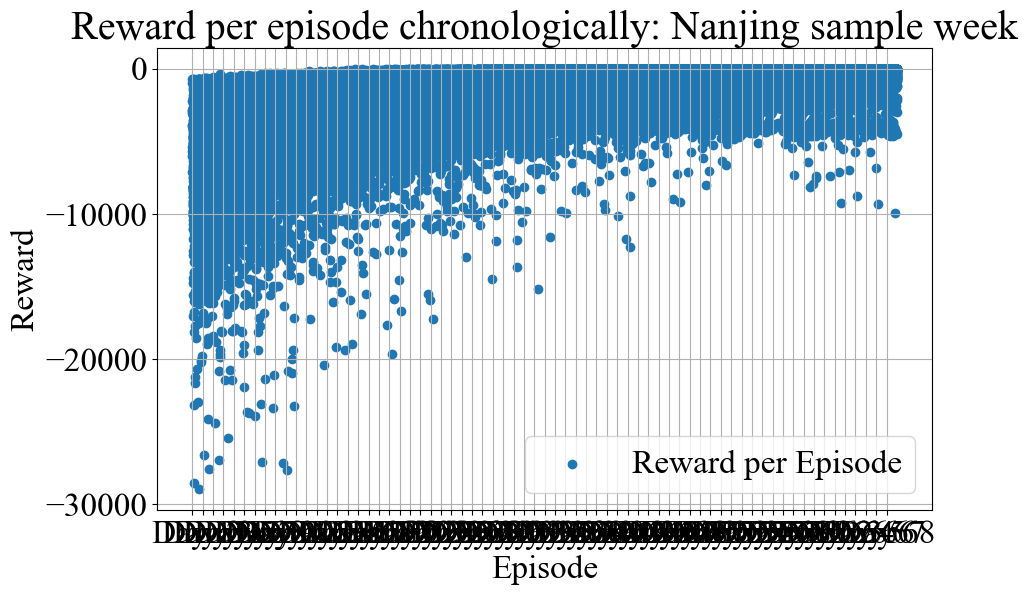

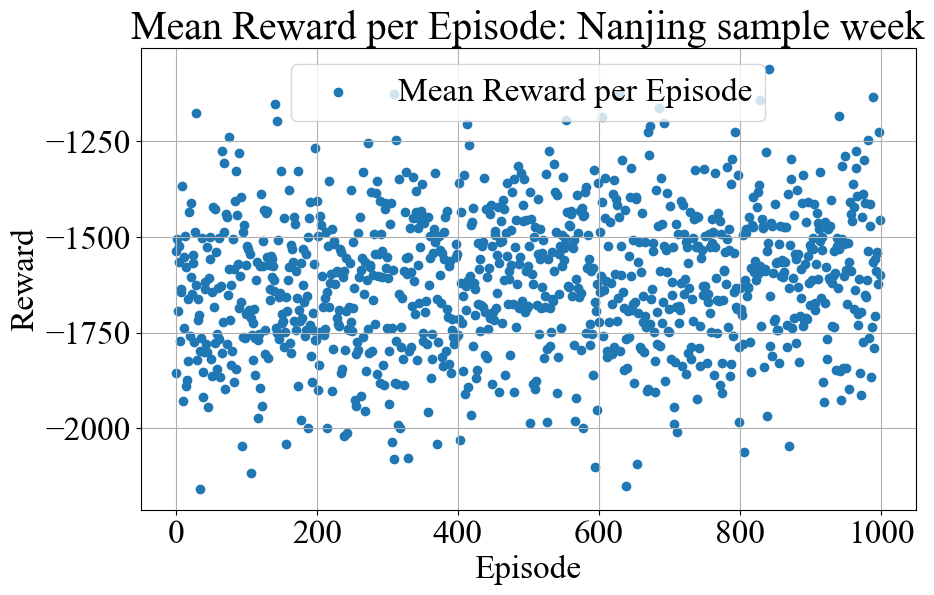

In [176]:
num_days = 68 # 28 for all sample weeks together
num_episodes_per_day=1000
exp_name="Nanging Sample Week"

analyse_convergence_x_episodes_per_day(num_days, num_episodes_per_day, training_total_reward_list, "results_nanjing_sample_week", "Nanjing sample week")


## 7.2 Analyse Convergence- Epochs on all days

In [61]:
def plot_epochs_reward(num_epochs, training_total_reward_list, exp_name):
    
    title=f"Reward per Episode: {exp_name}" if exp_name else "Reward per epoch"
    # Plotting the array with dots
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(training_total_reward_list)), training_total_reward_list, label='Reward per Epoch', marker='o', s=10)
    plt.xlabel('Epoch')
    
    # Determine the step size for the x-ticks
    total_points = len(training_total_reward_list)
    step_size = max(total_points // num_epochs, 1)
    
    # Generate the positions for the x-ticks
    x_ticks = range(0, total_points, max(step_size * 100, 100))

    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(list(x_ticks) + [total_points], fontsize='small')
    plt.show()

In [105]:
def plot_day_learning(rewards, title):
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(rewards)), rewards, label='Reward per Episode', marker='o')
    plt.xlabel('Epoch')

    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()    

def plot_days_learning_curve(days_dict, exp_name):
    for day in days_dict.keys():
        title = f"{exp_name}: day {day}"
        plot_day_learning(days_dict[day], title)

def plot_mean_reward_per_epoch( num_days, num_epochs,daily_reward_dict, exp_name):
    mean_reward_arr  = []
    for epoch in range(num_epochs):
        mean_reward = sum([daily_reward_dict[day][epoch] for day in range(num_days)]) / num_days
        mean_reward_arr.append(mean_reward)

        
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(mean_reward_arr)), mean_reward_arr, label='Mean Reward per Epoch', marker='o')
    plt.xlabel('Epoch')

    plt.ylabel('Reward')
    plt.title(f"{exp_name}: Mean reward per epoch")
    plt.legend()
    plt.grid(True)
    plt.show()    
        

def plot_days_from_epochs_run(num_days, num_epochs, training_total_reward_list, exp_name):
    days_dict = {}
    for day in range(num_days):
        days_dict[day] = []
        for i in range(len(training_total_reward_list)):
            if i % num_days == day:
                days_dict[day].append(training_total_reward_list[i])
    plot_days_learning_curve(days_dict, exp_name)
    plot_mean_reward_per_epoch(num_days, num_epochs,days_dict, exp_name)
            

### Plot daily reward per episode, and average per episode 

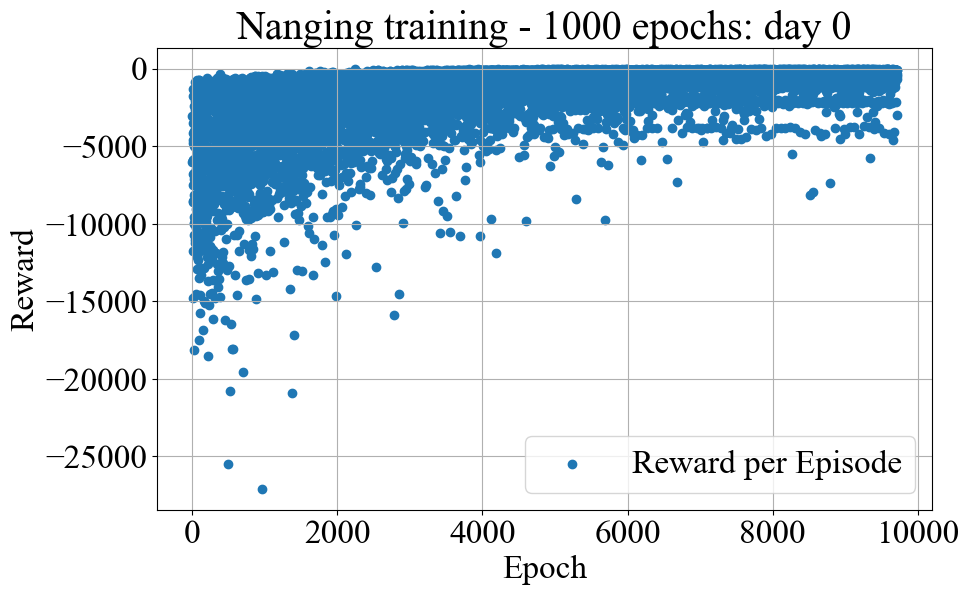

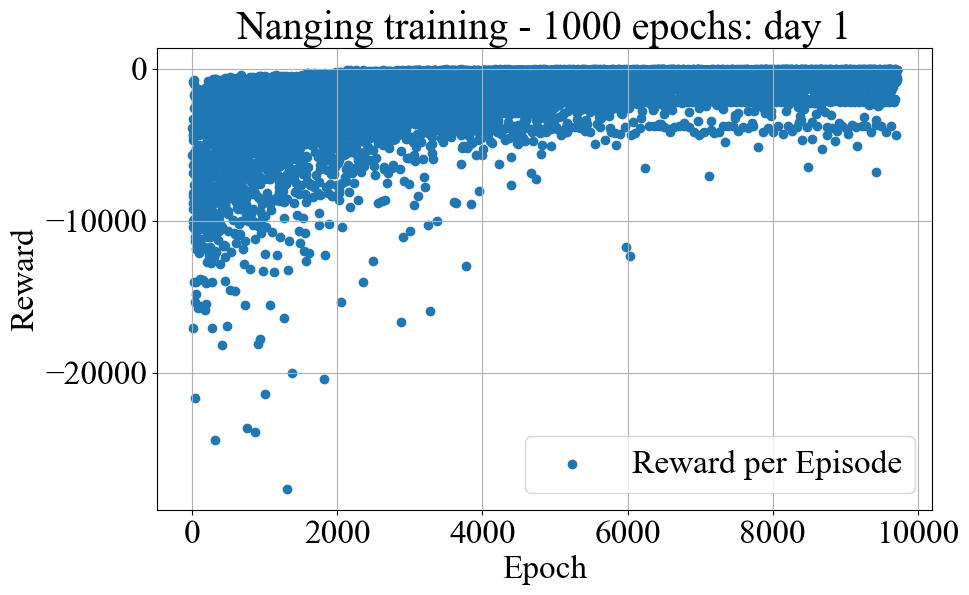

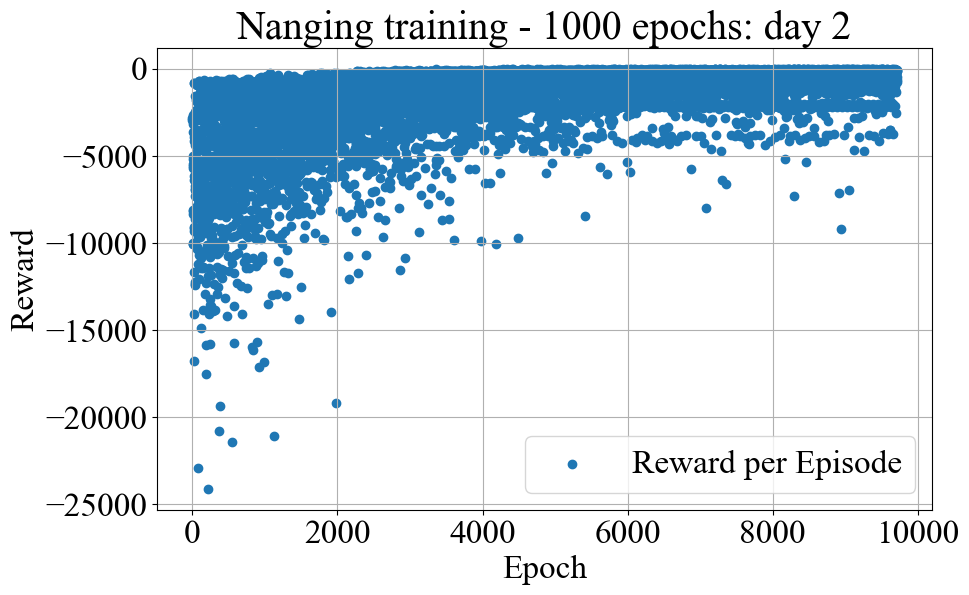

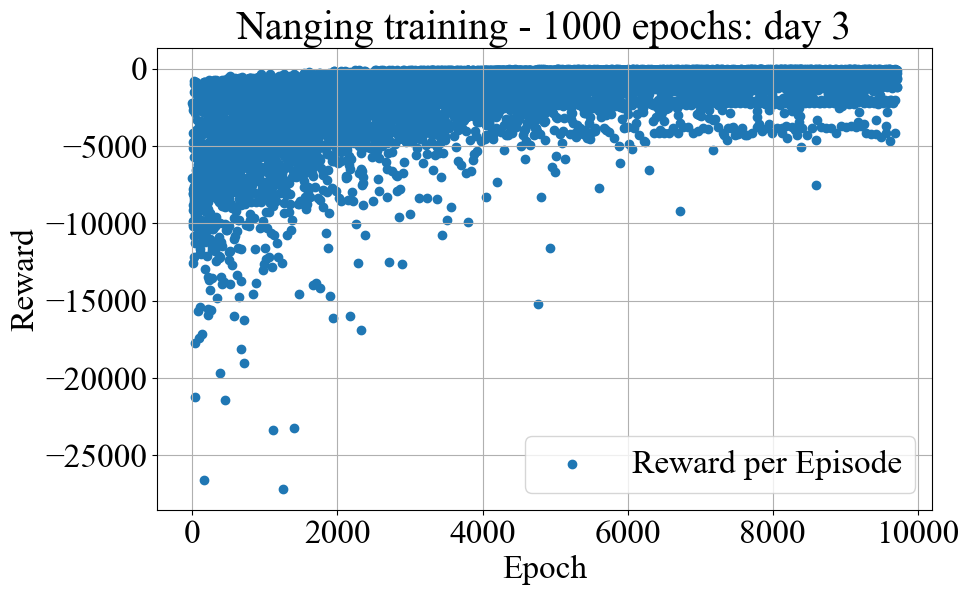

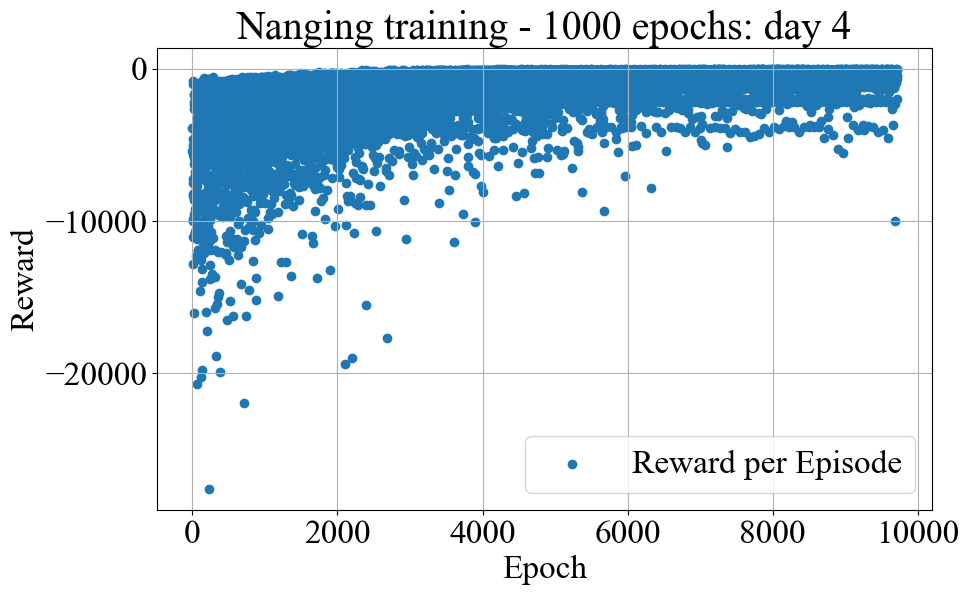

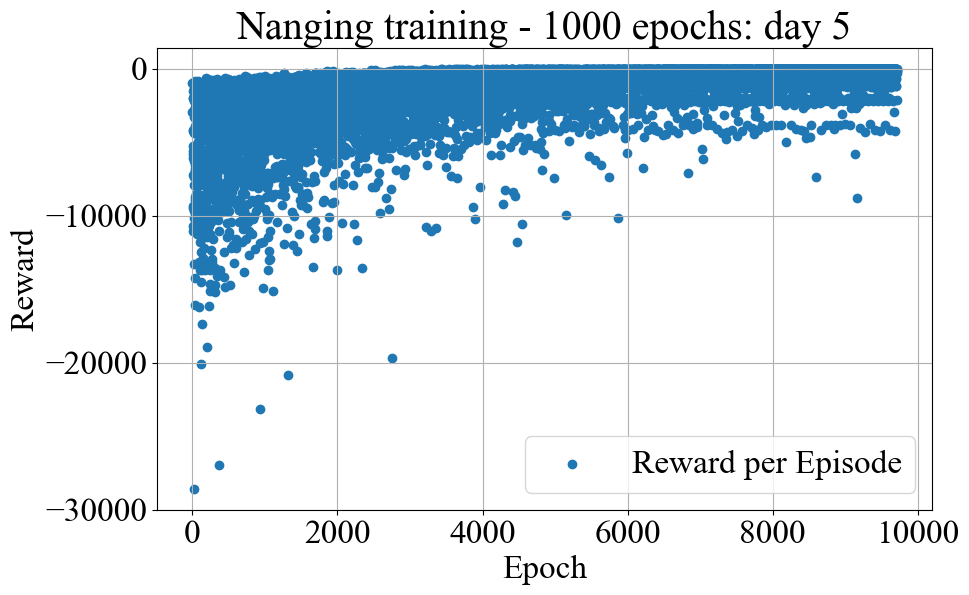

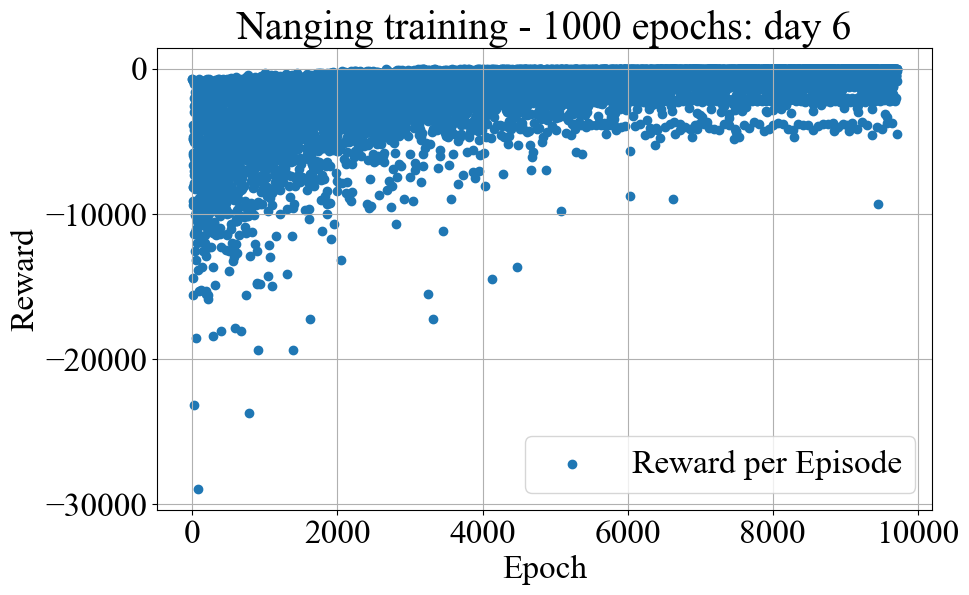

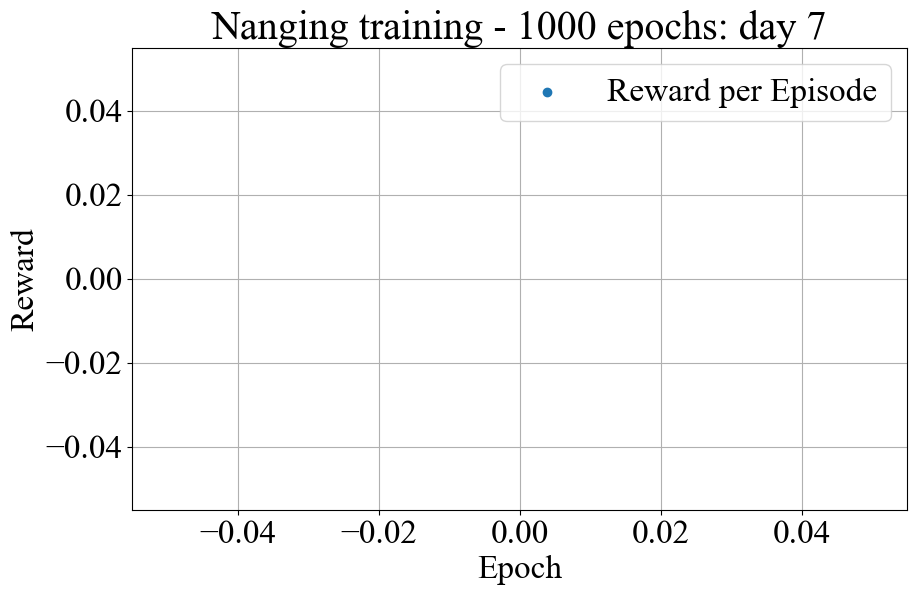

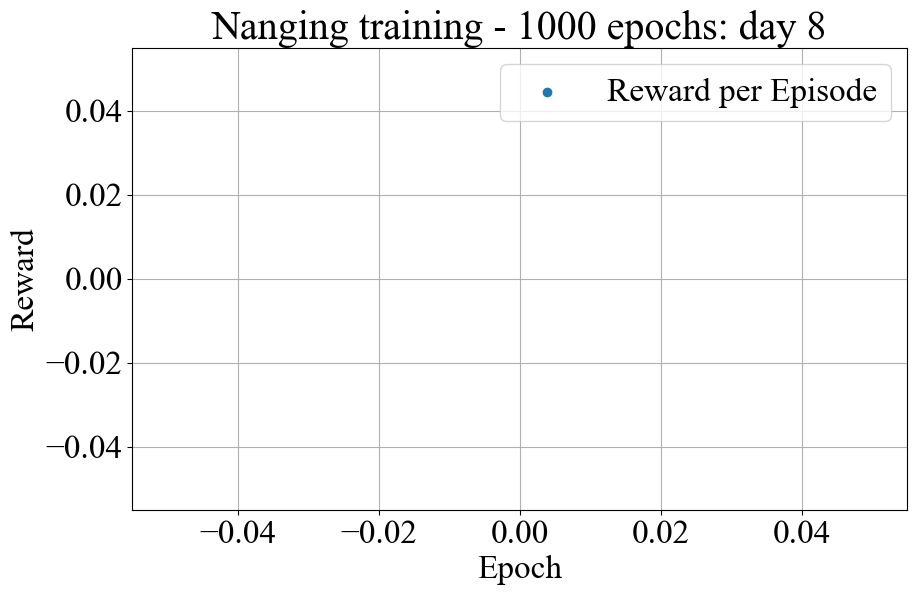

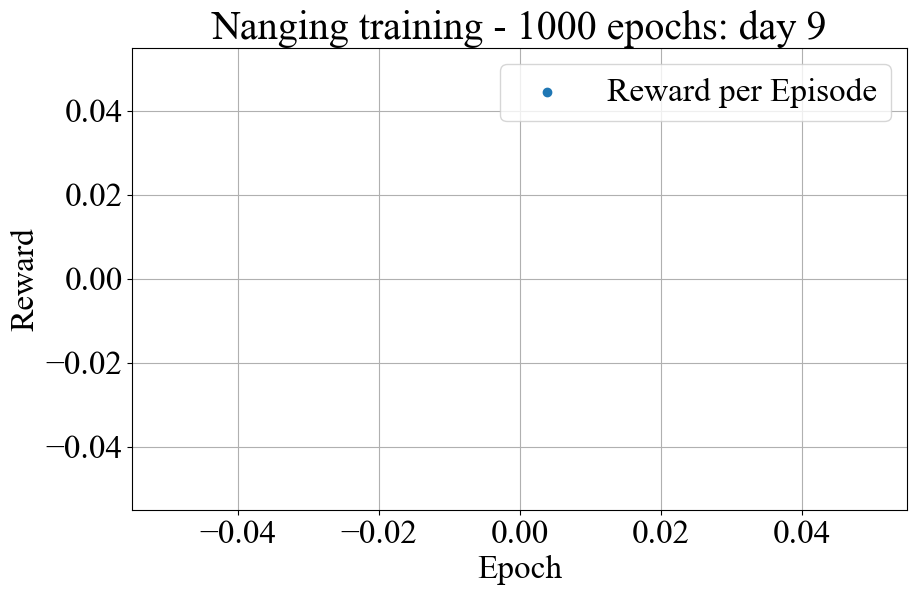

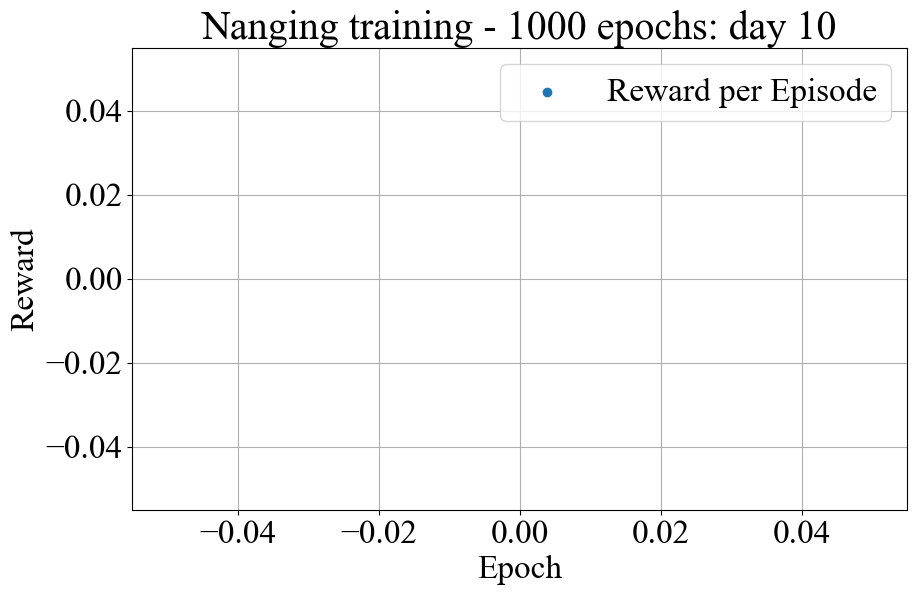

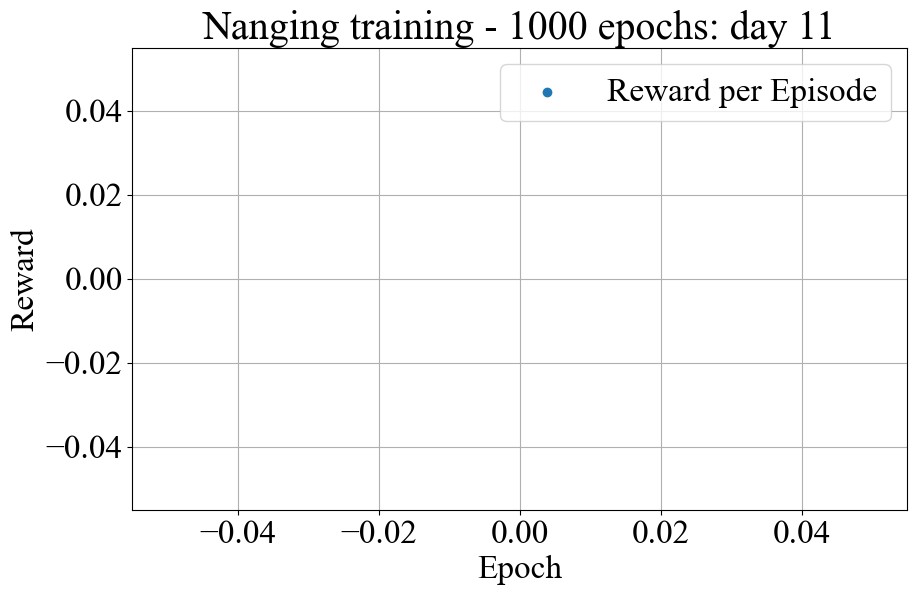

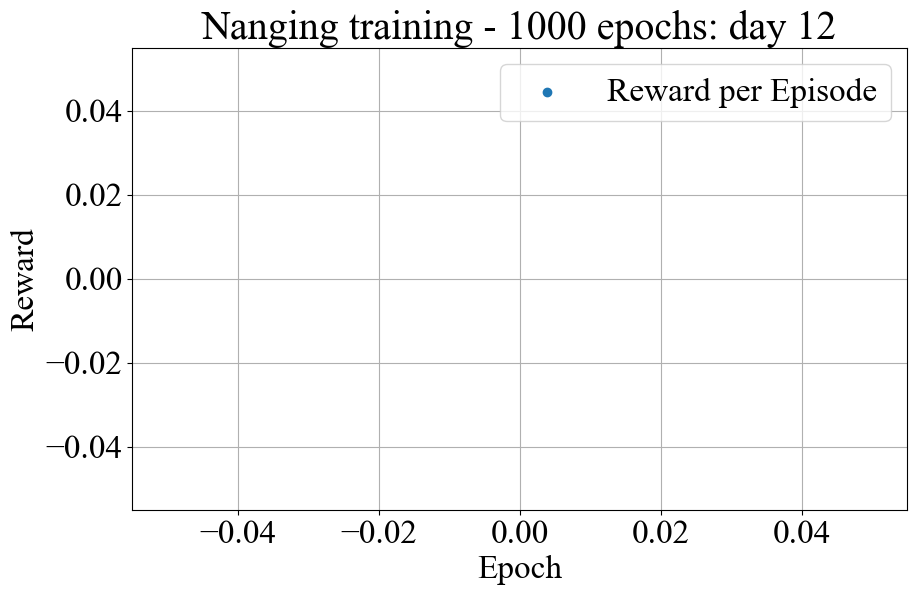

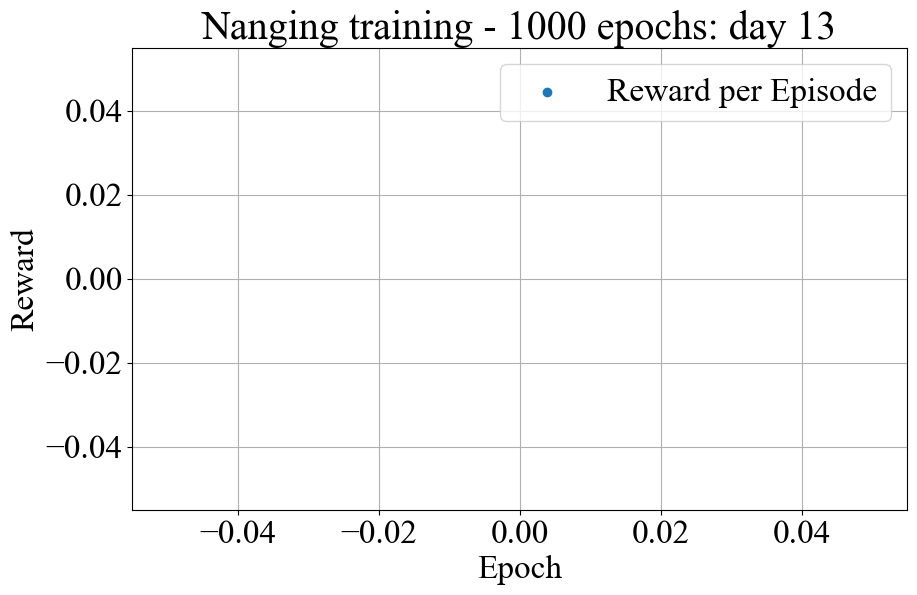

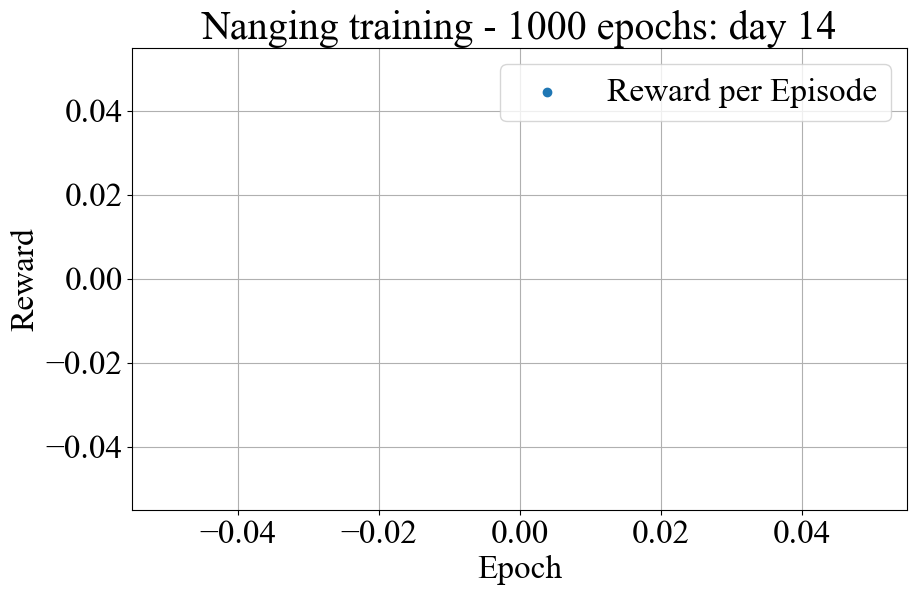

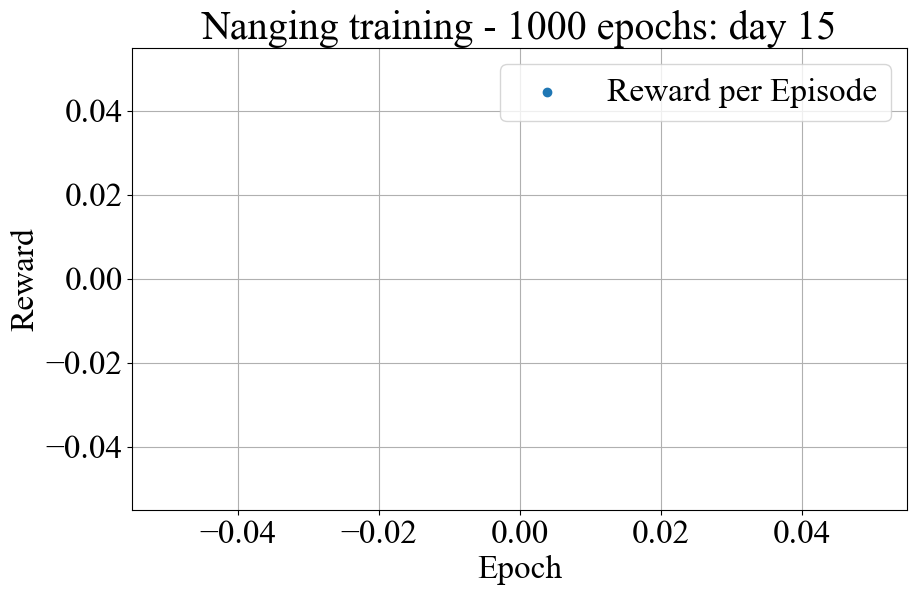

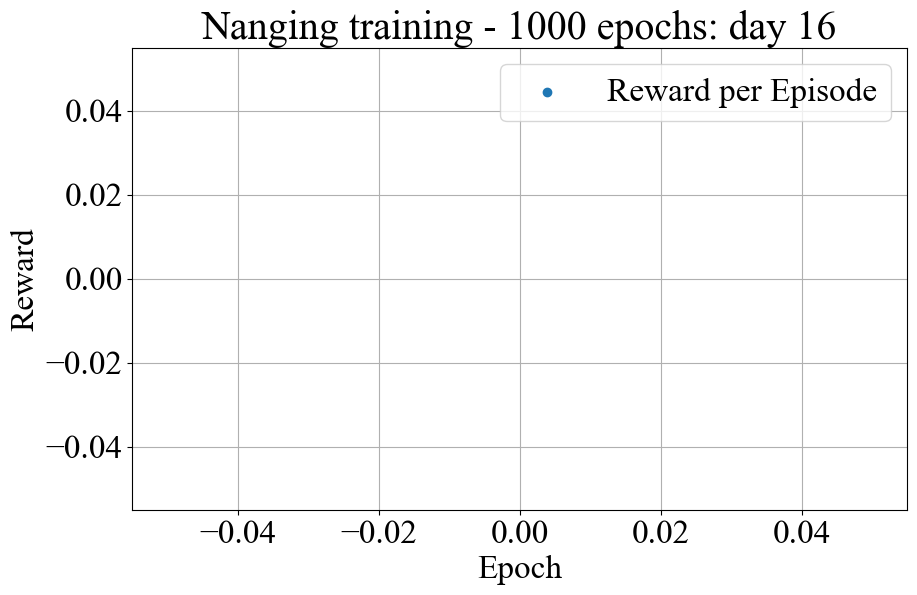

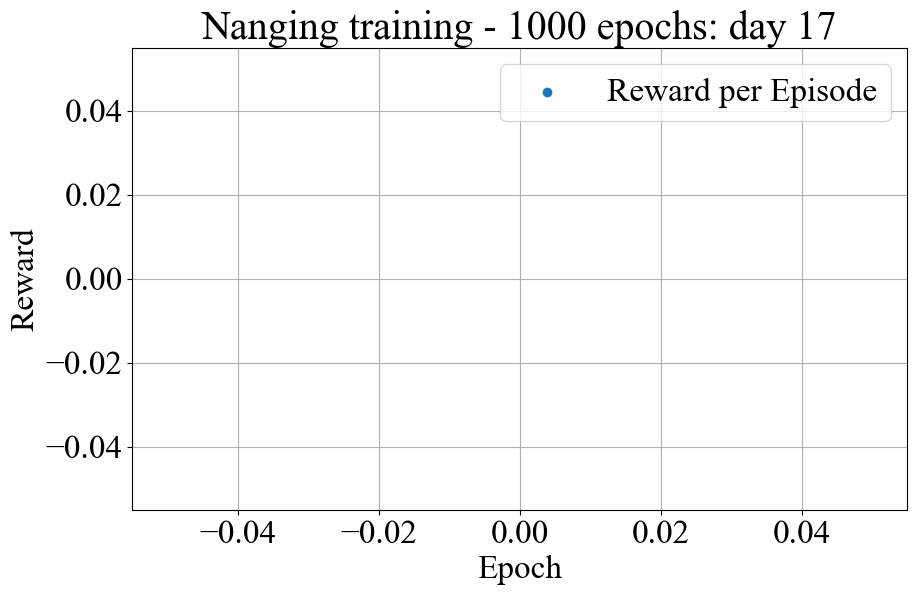

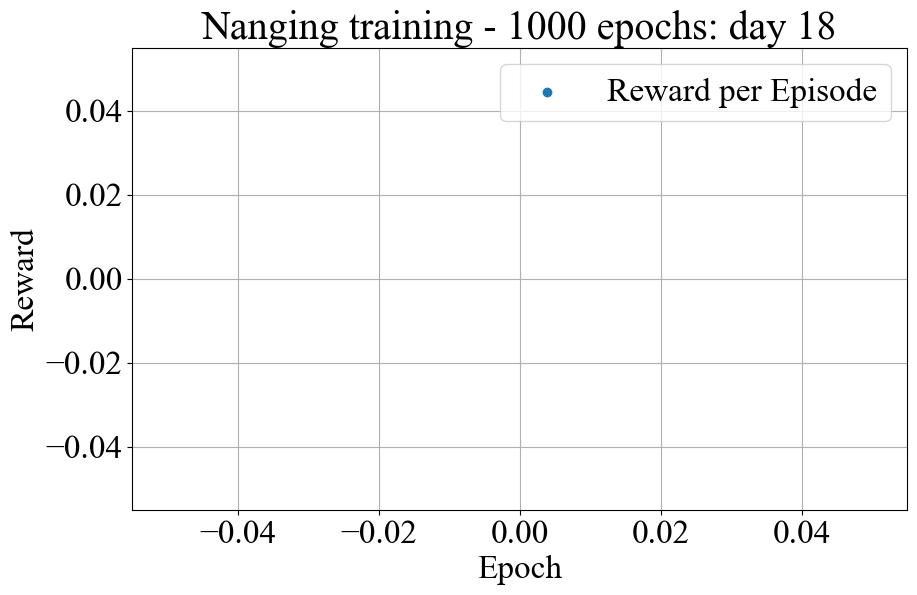

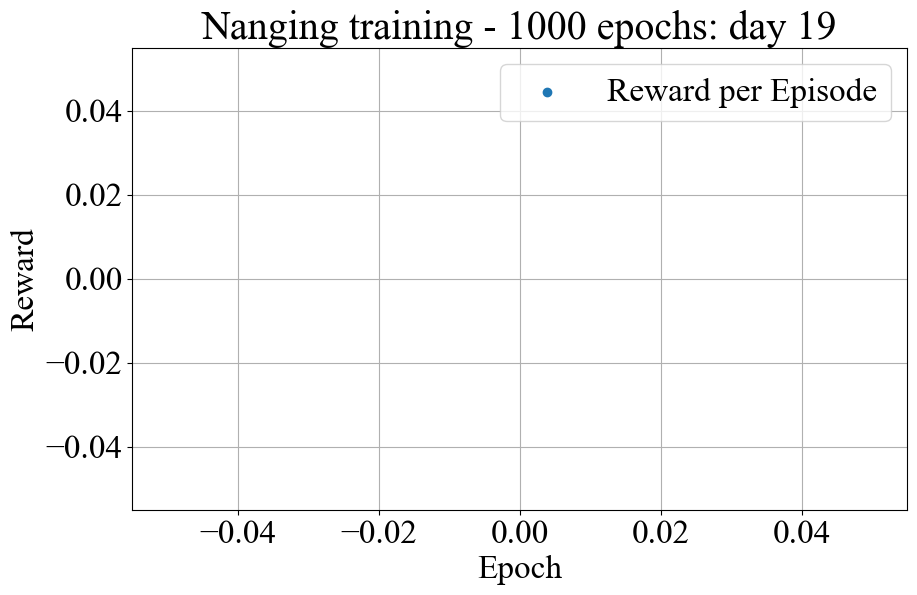

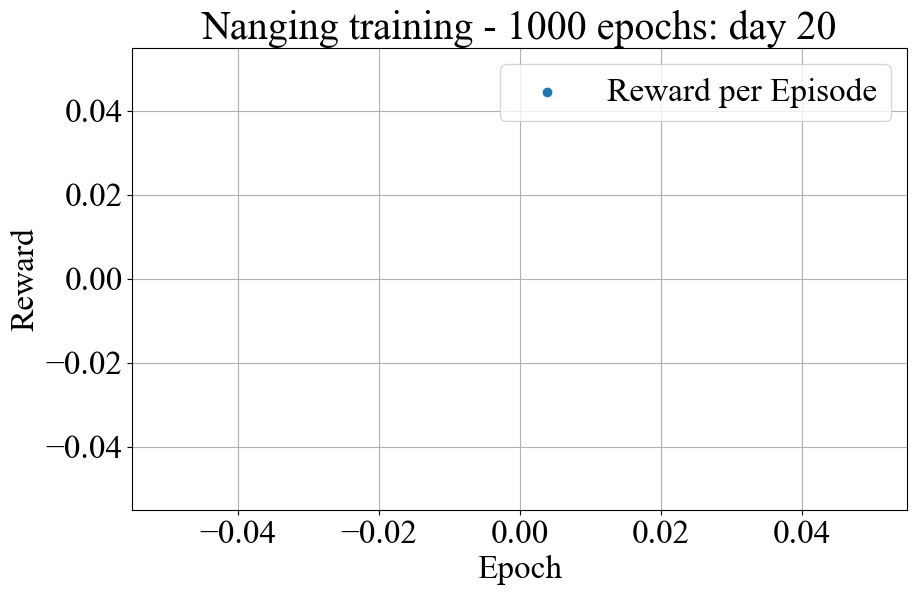

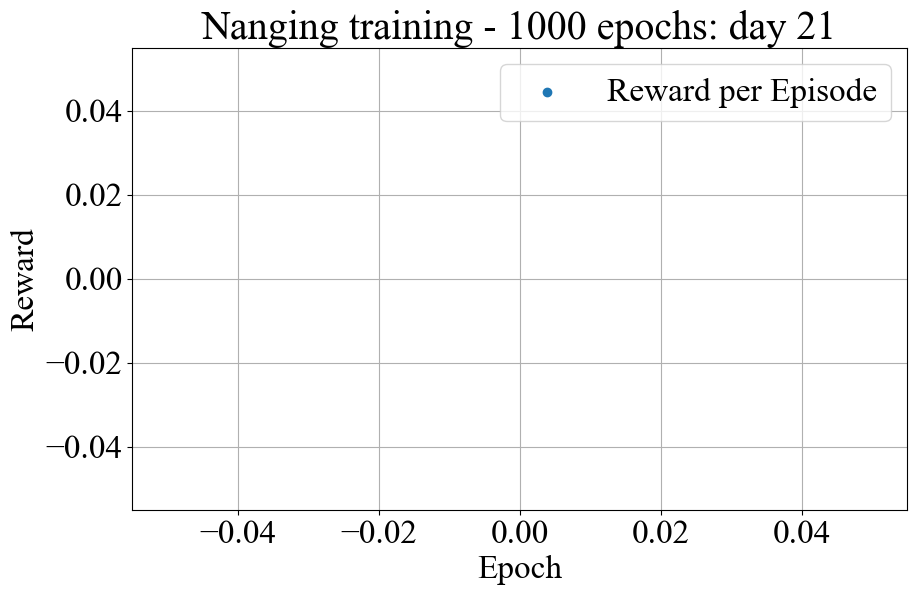

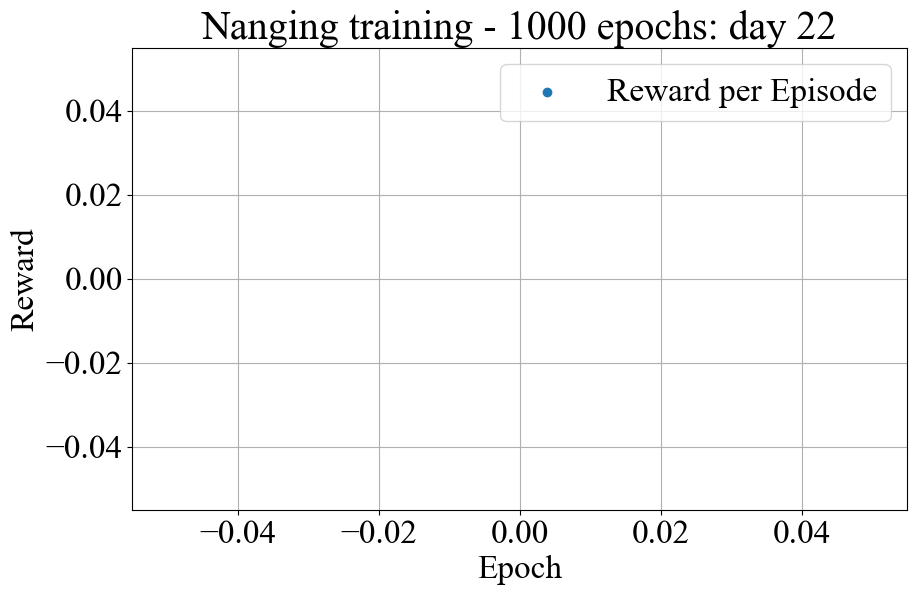

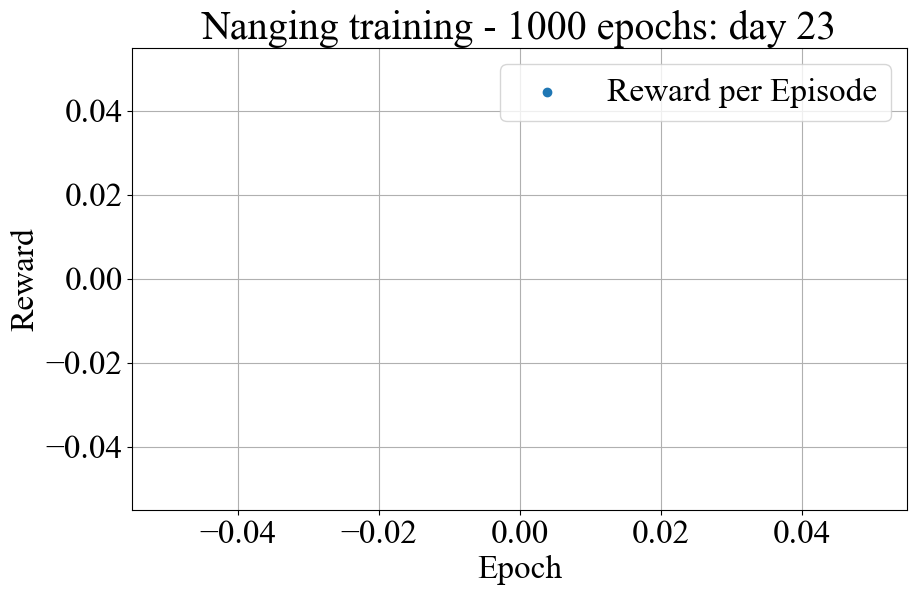

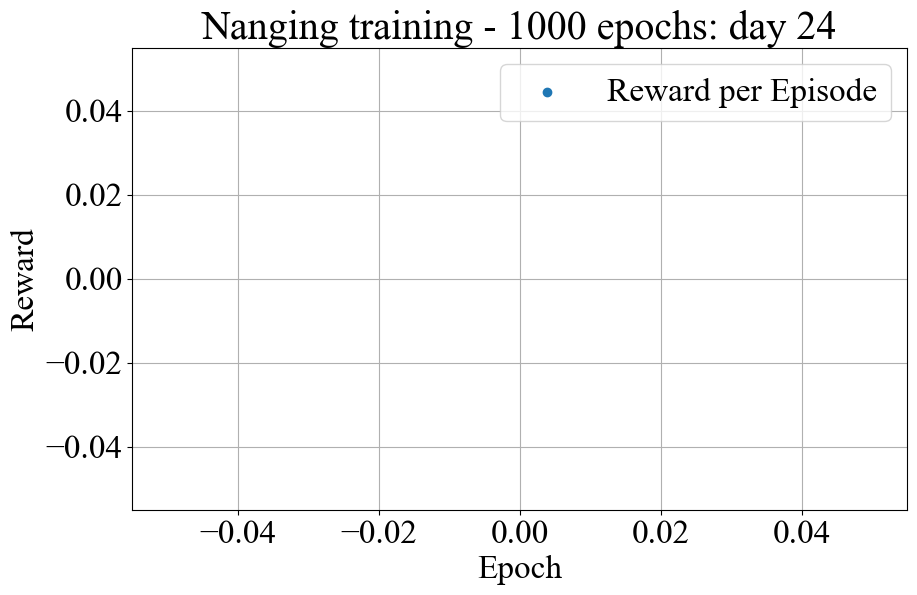

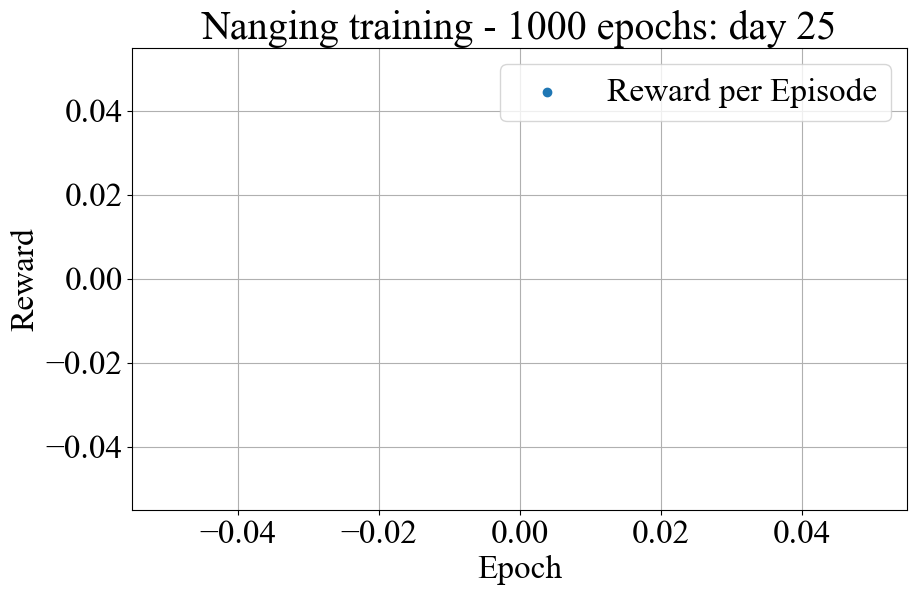

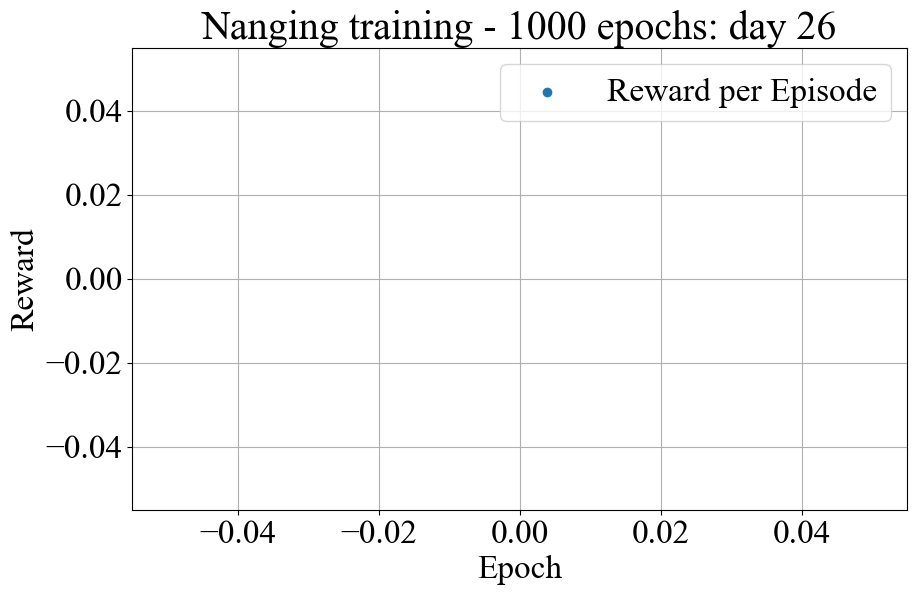

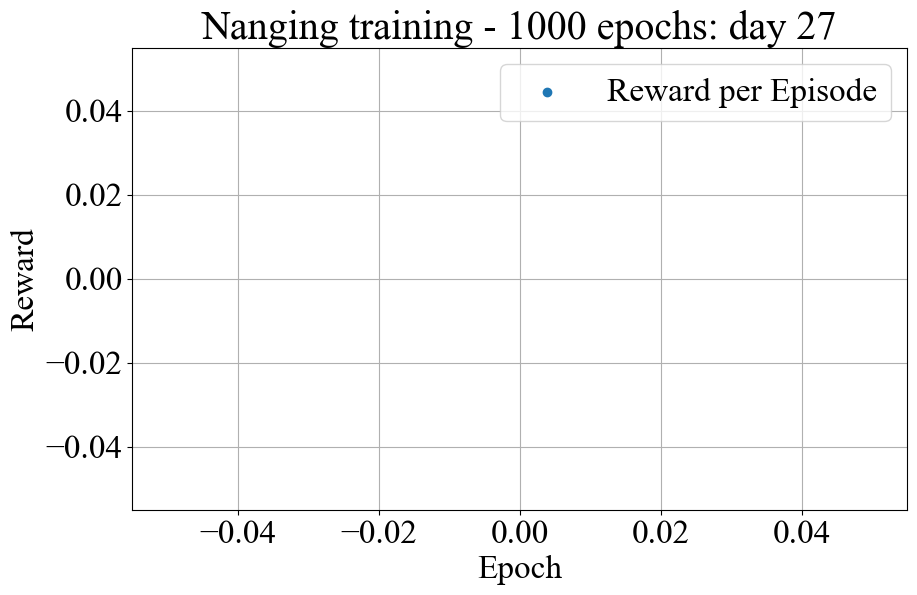

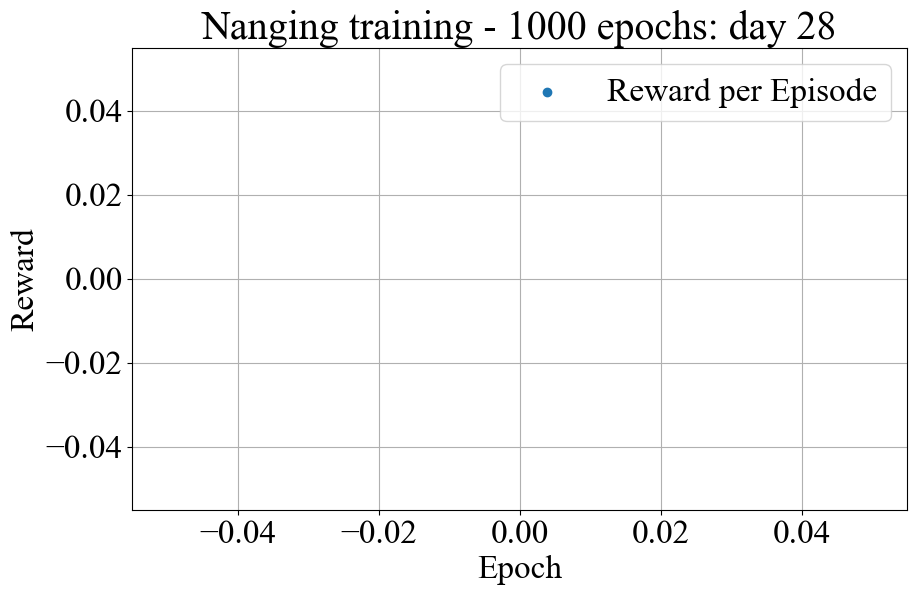

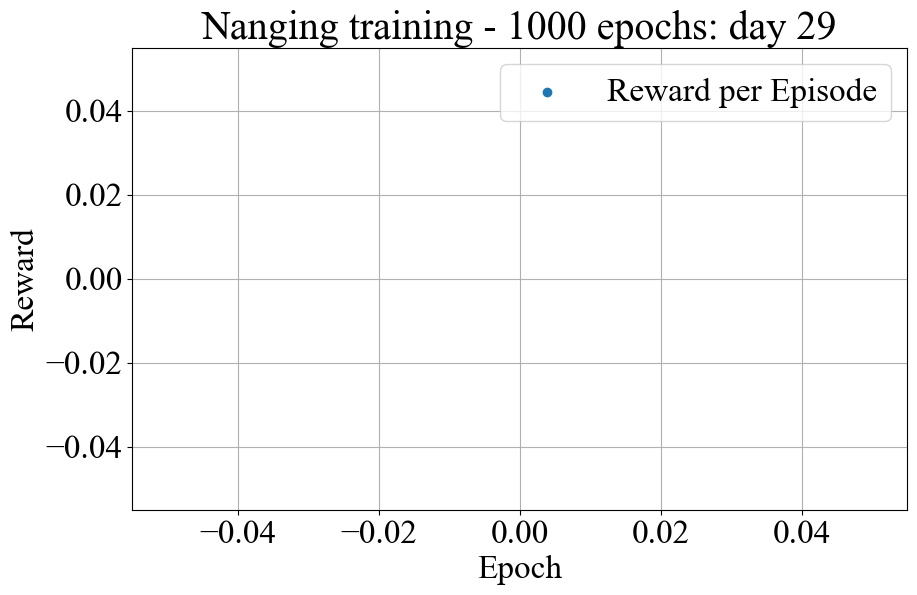

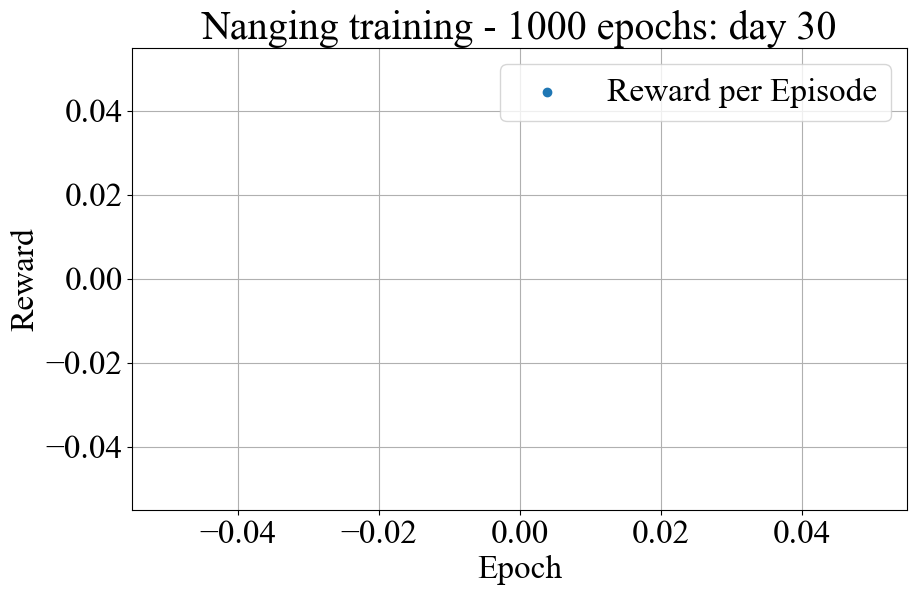

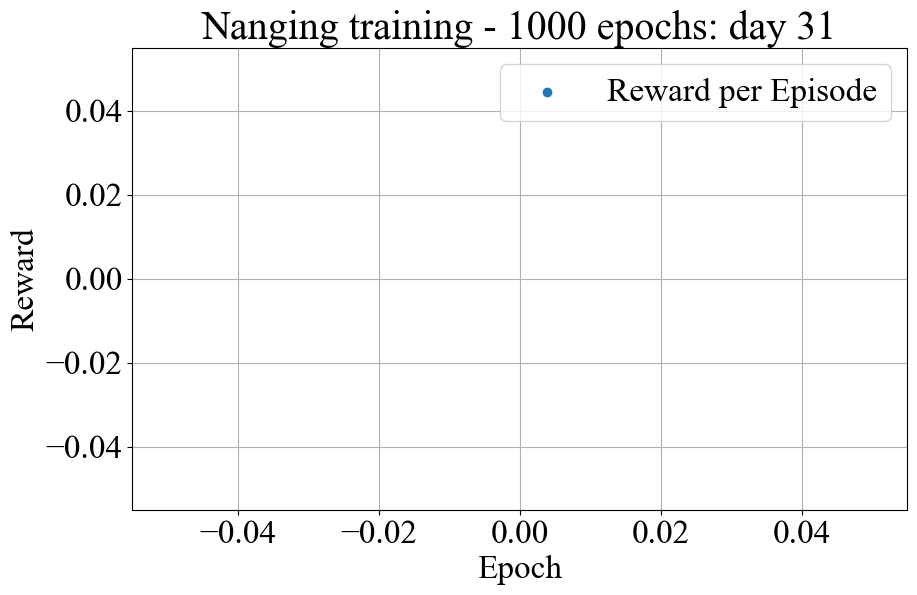

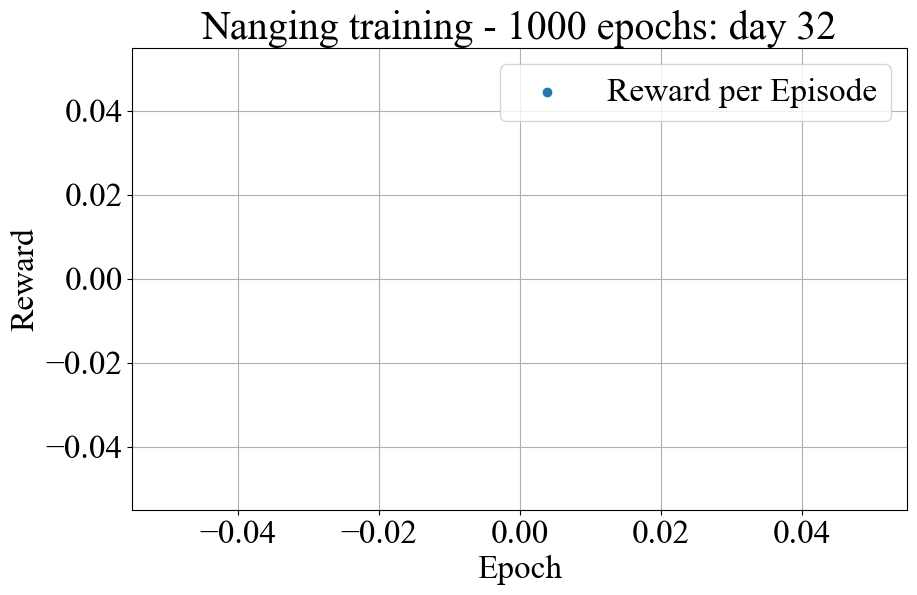

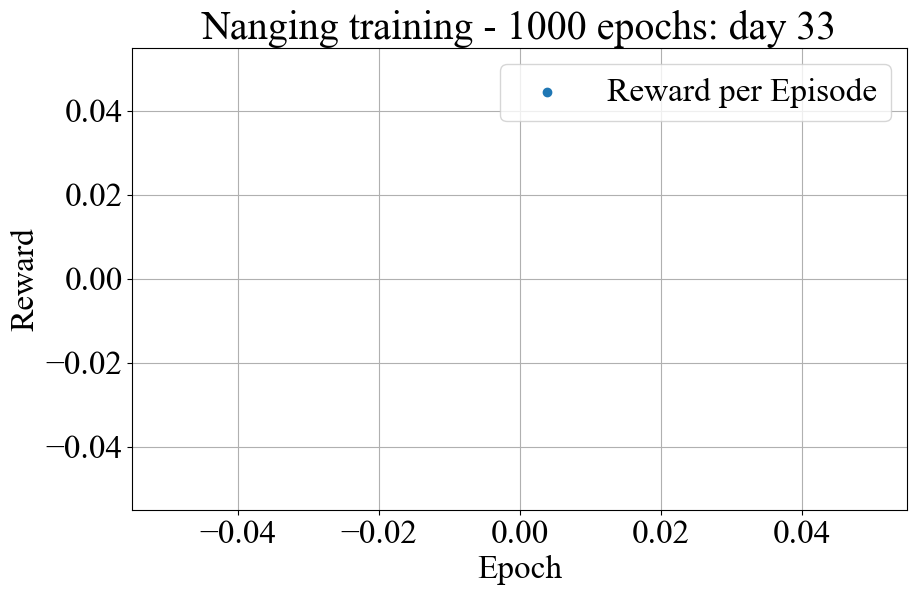

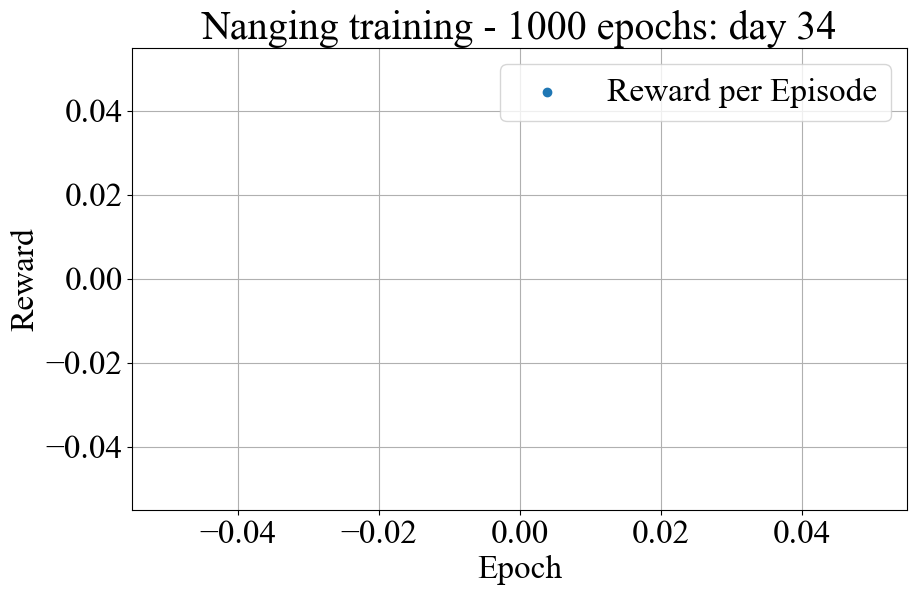

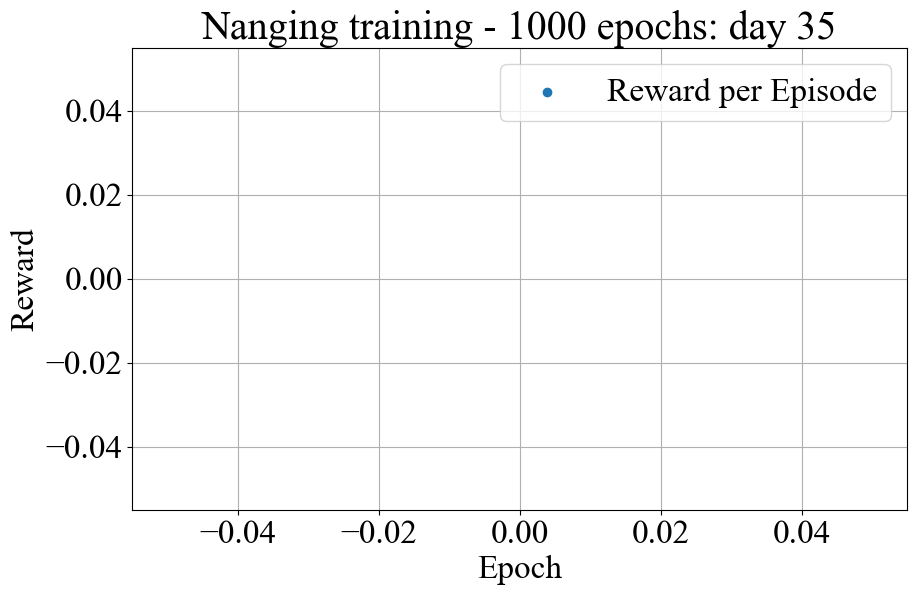

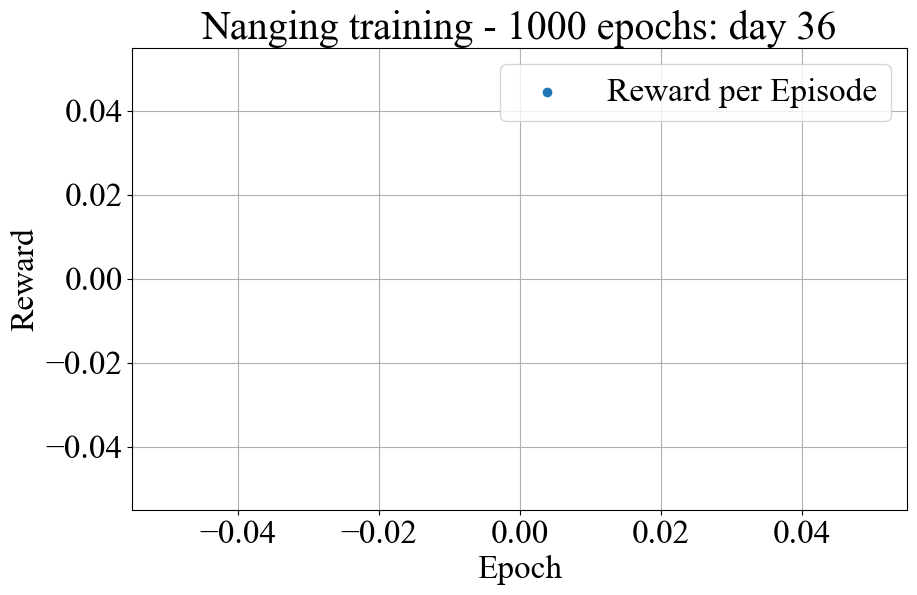

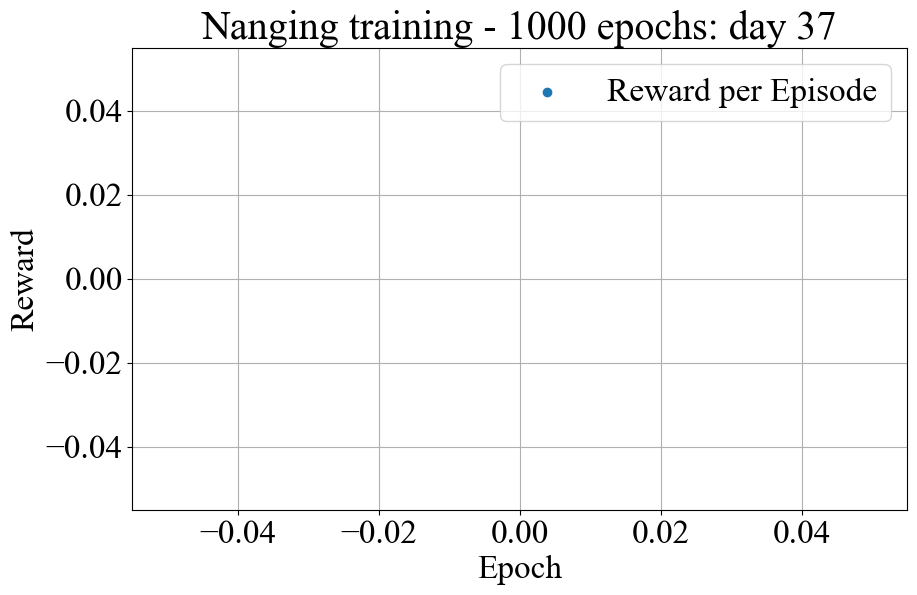

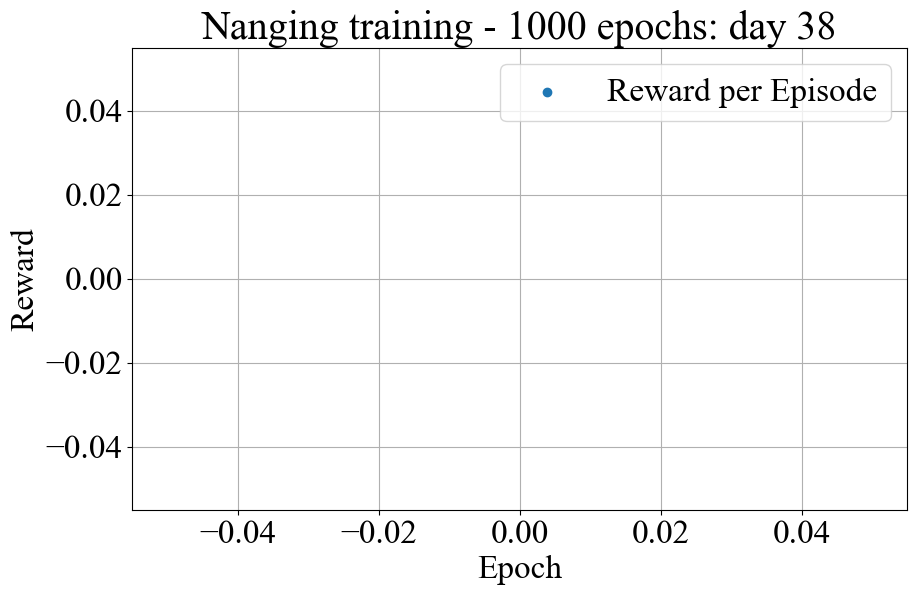

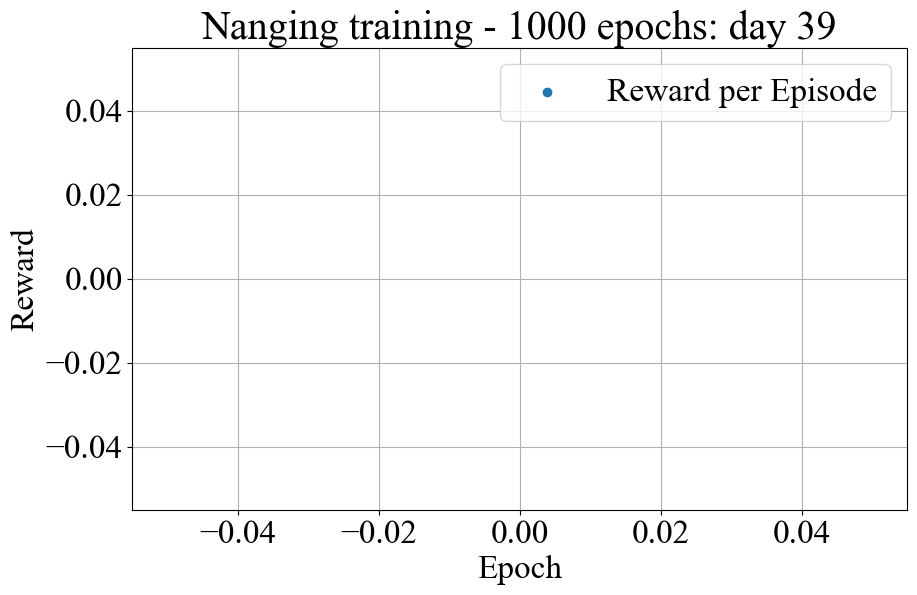

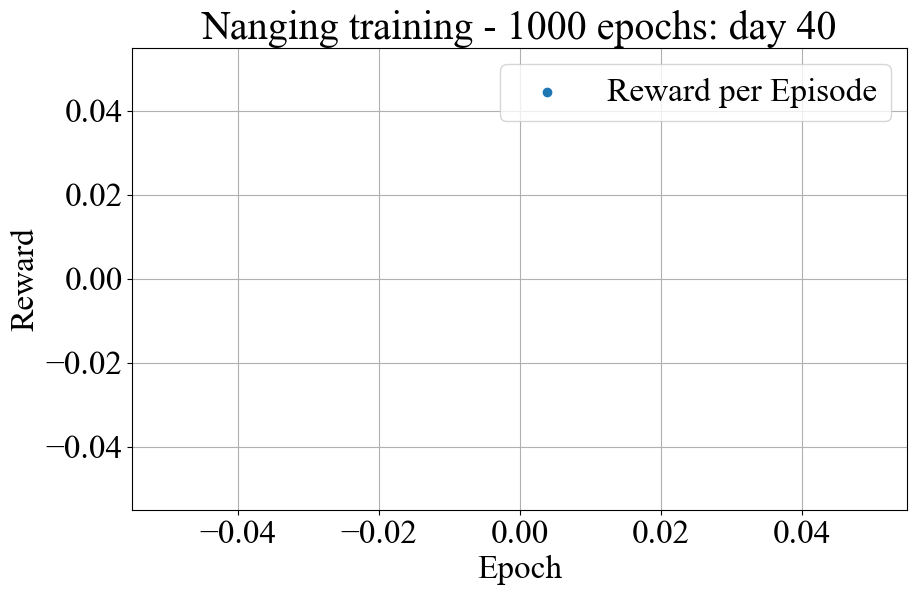

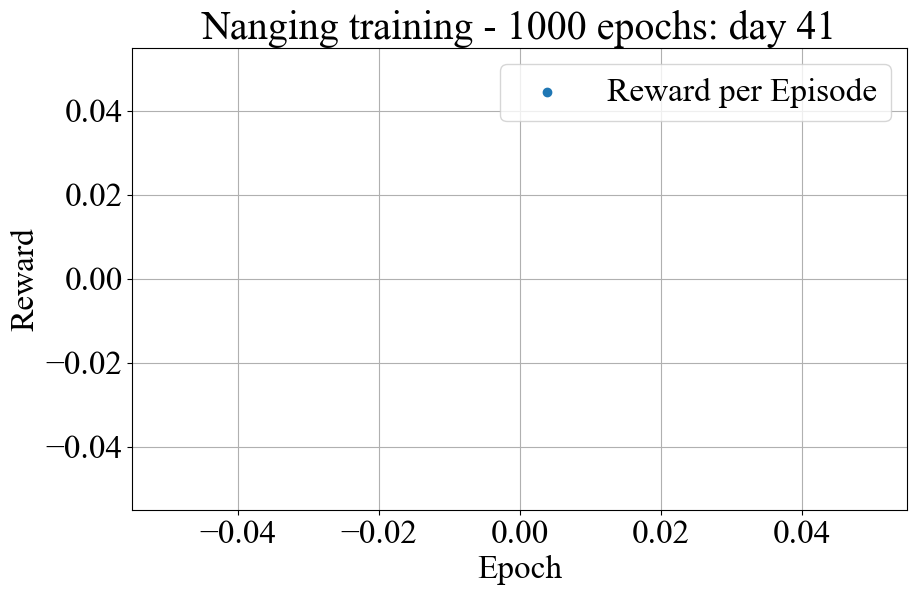

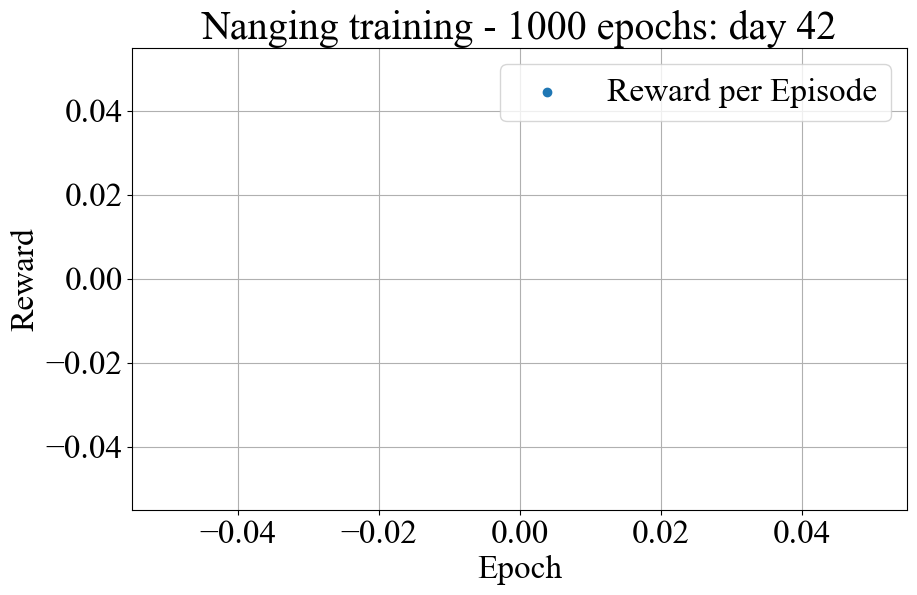

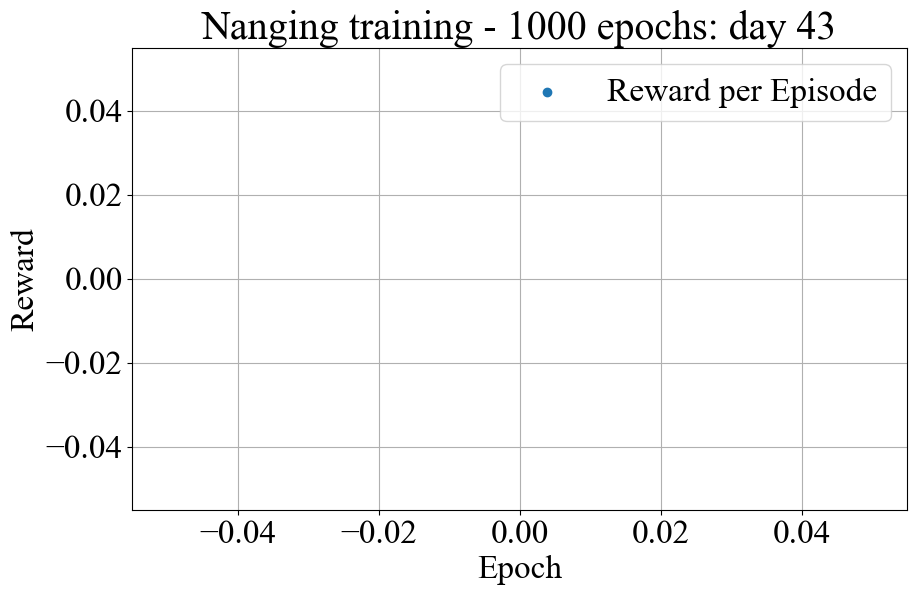

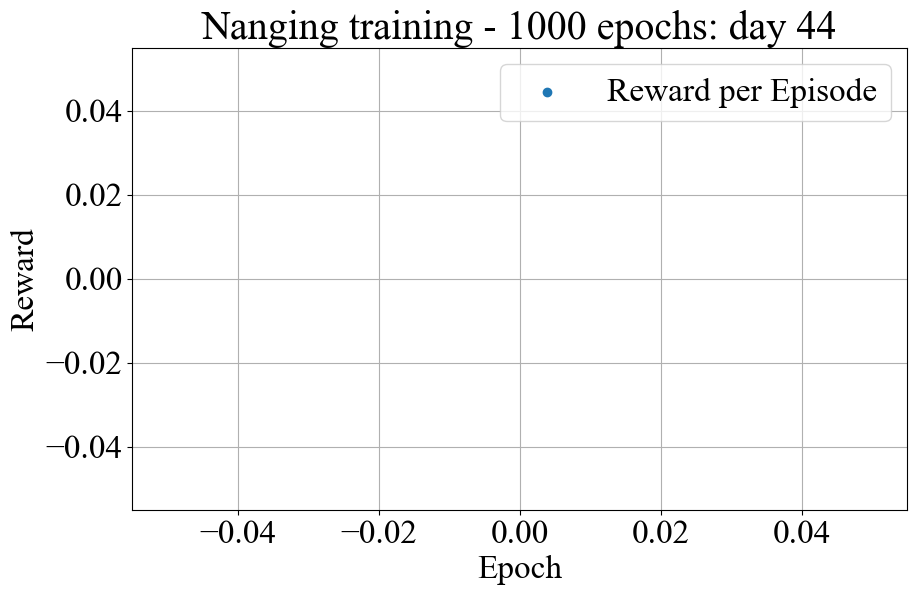

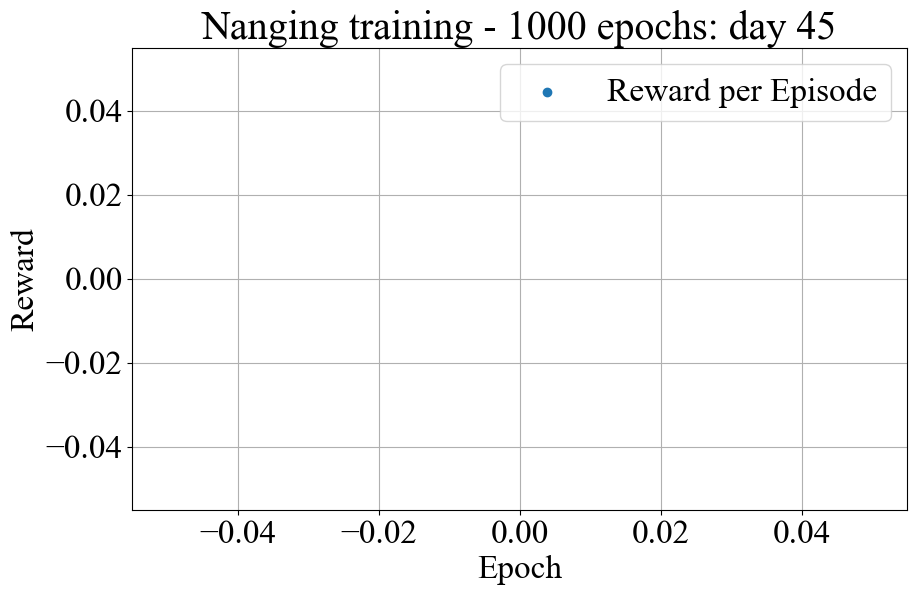

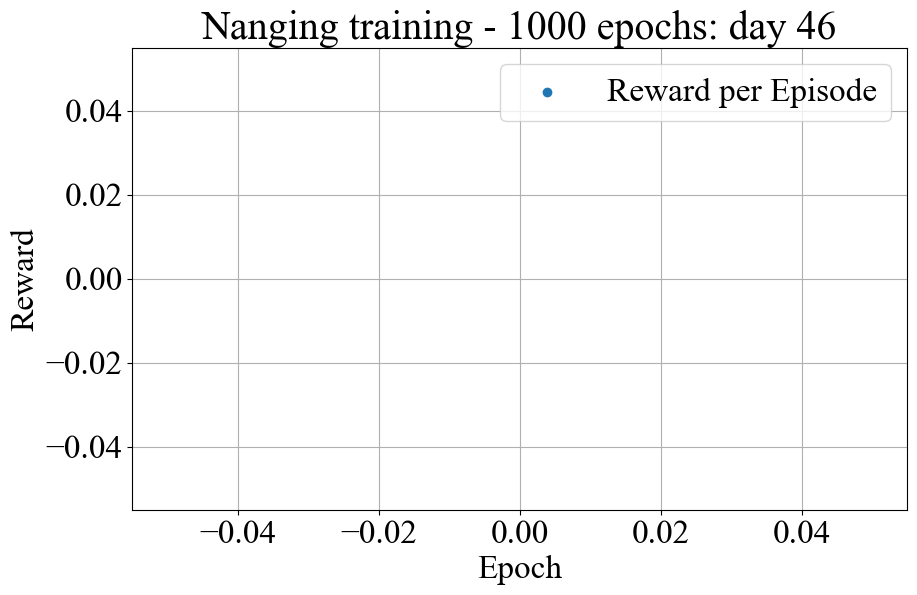

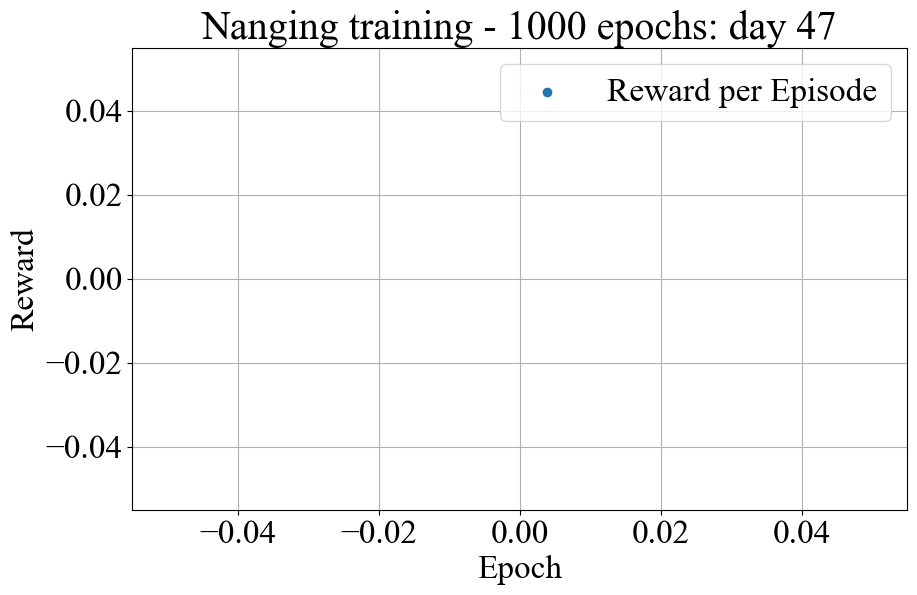

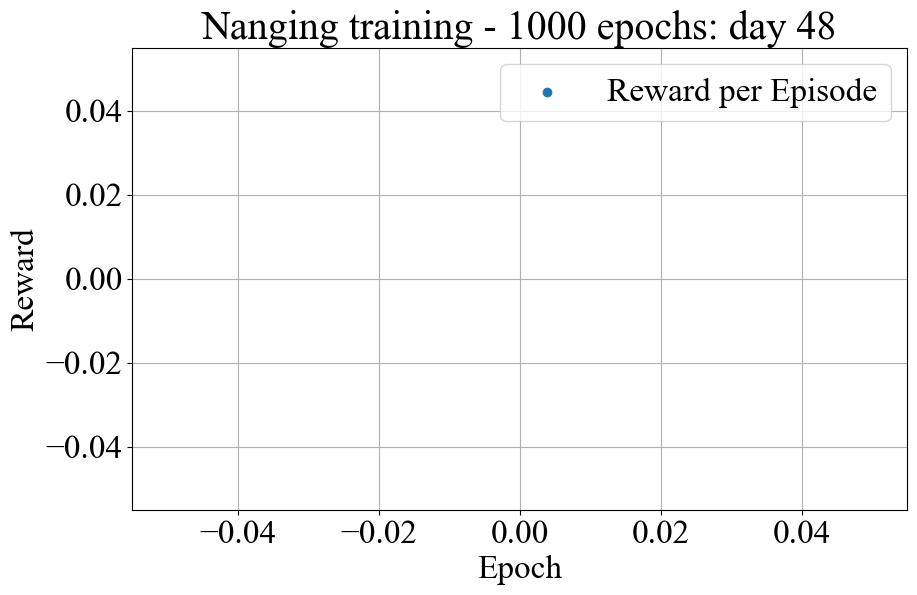

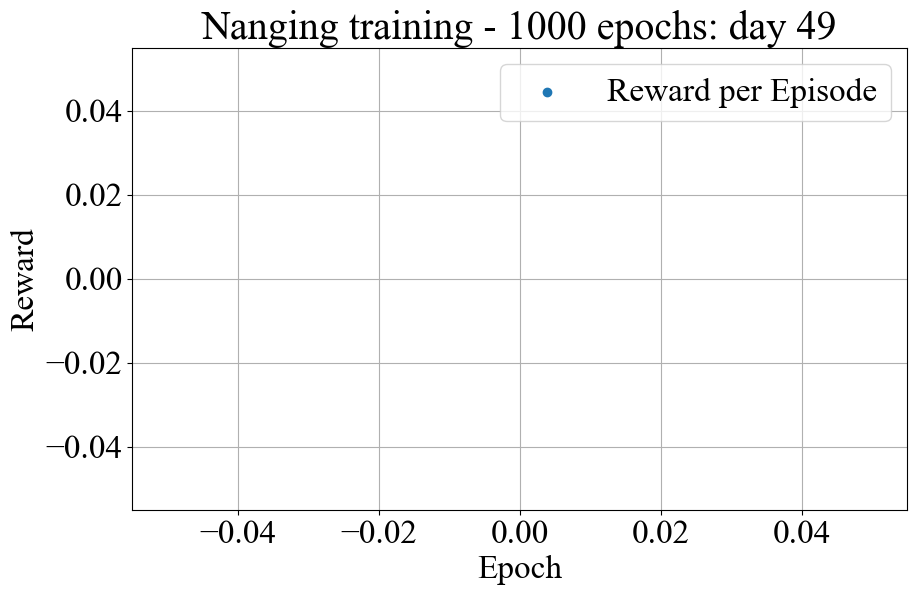

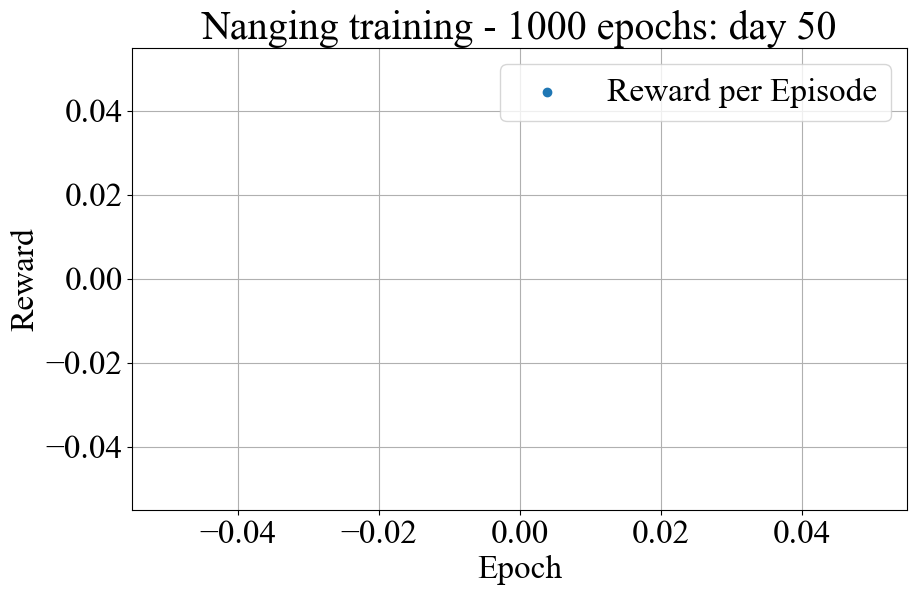

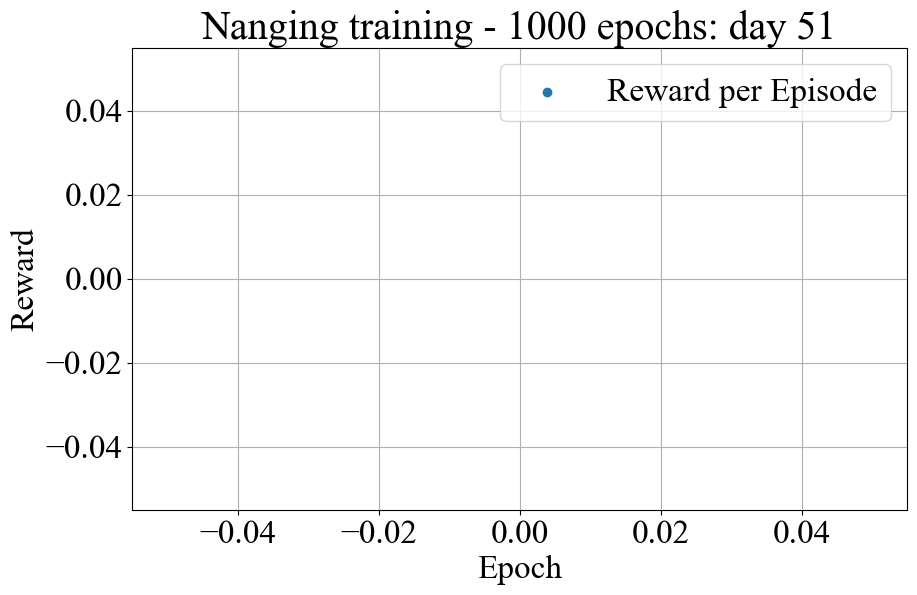

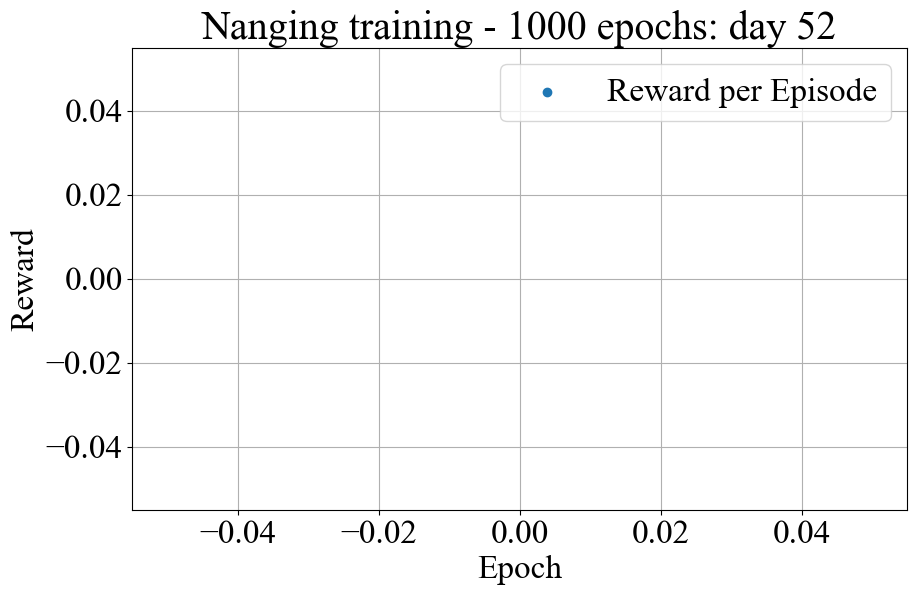

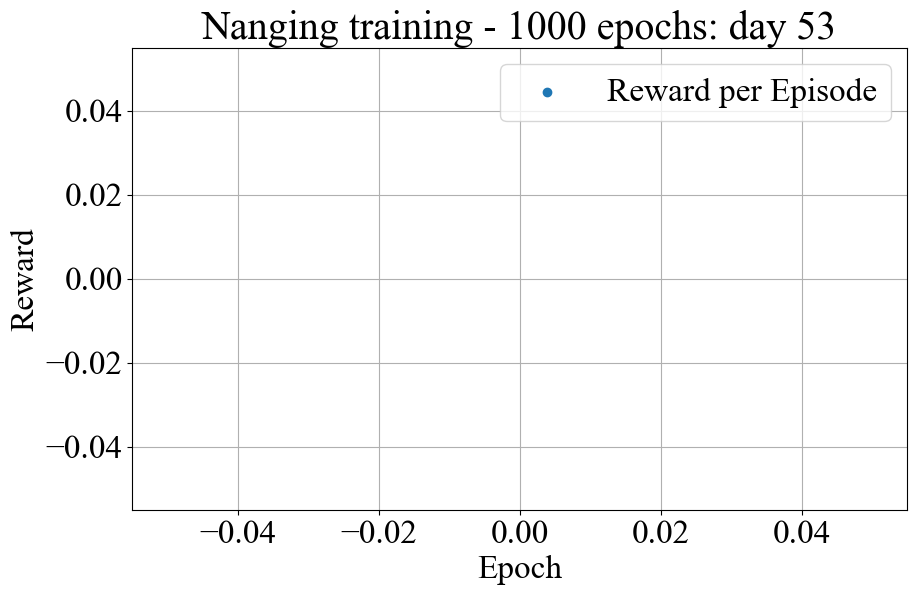

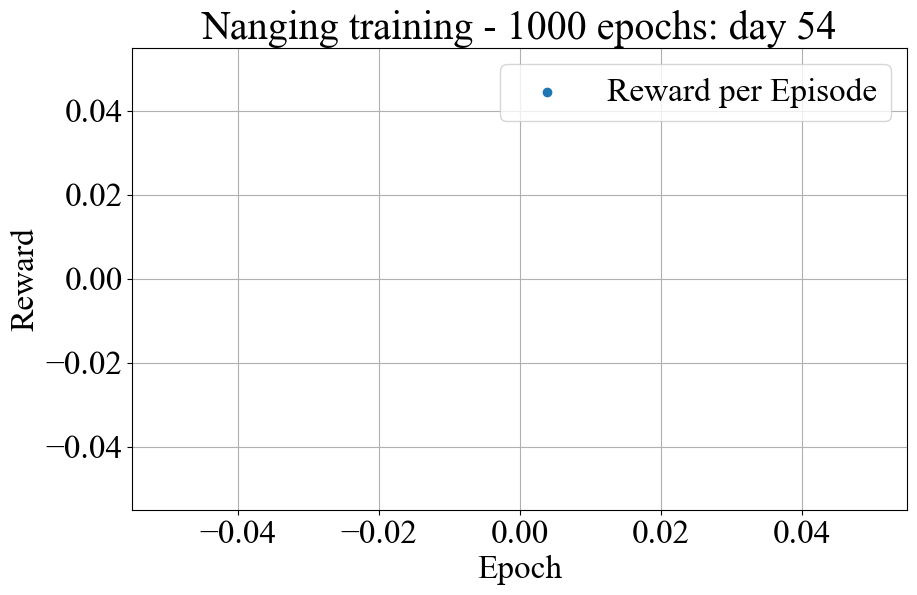

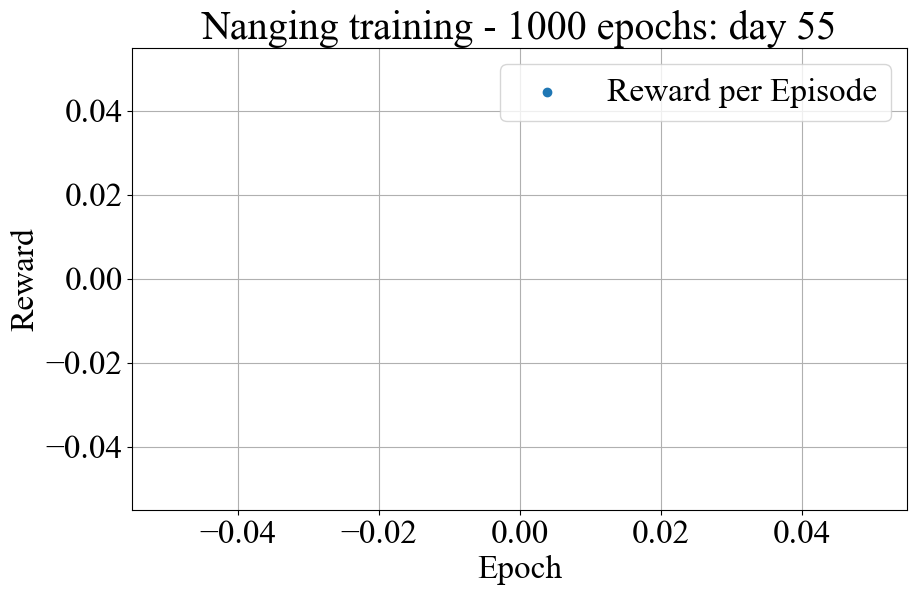

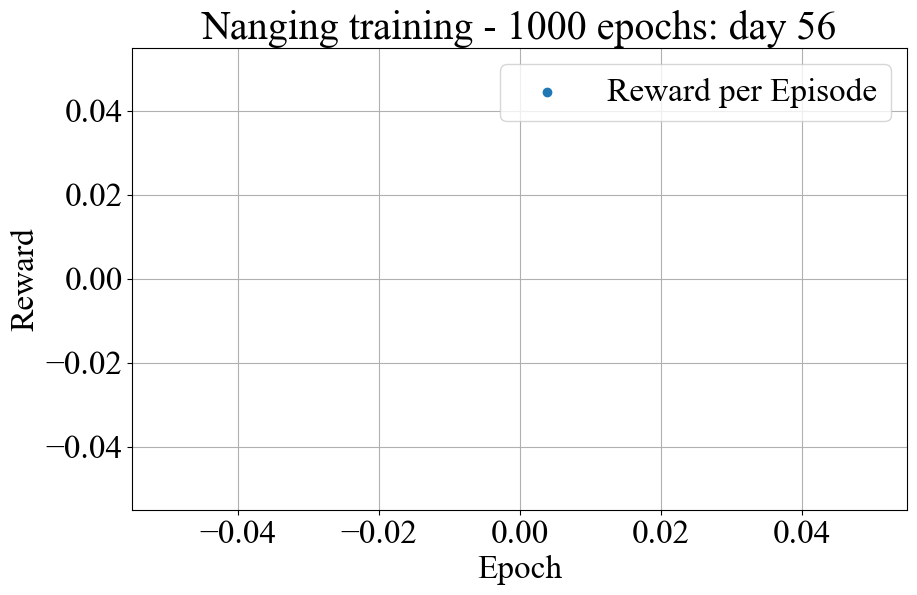

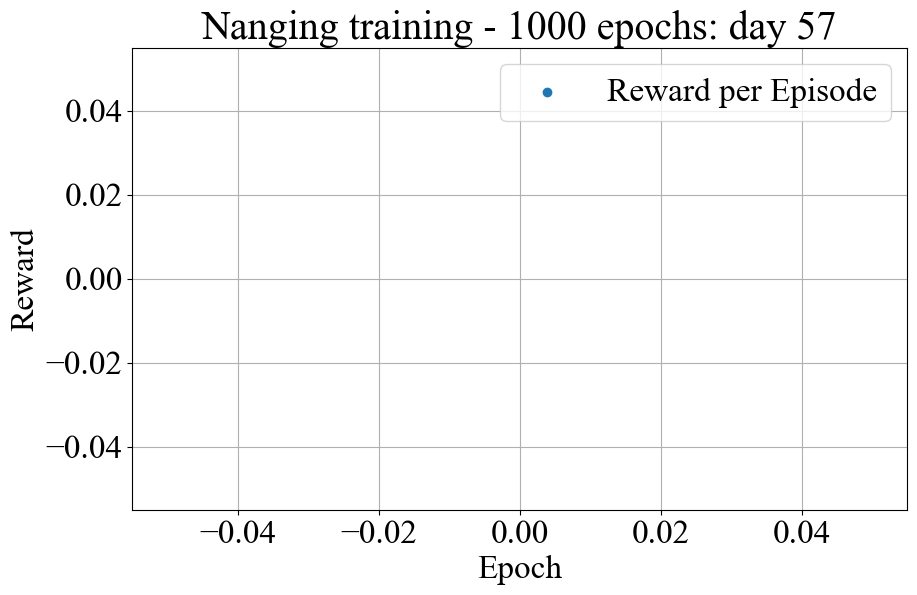

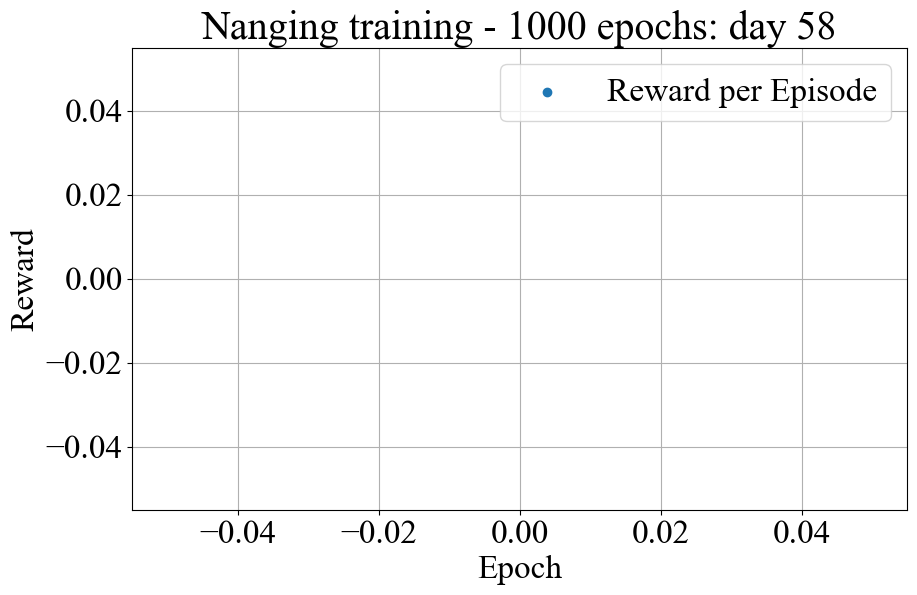

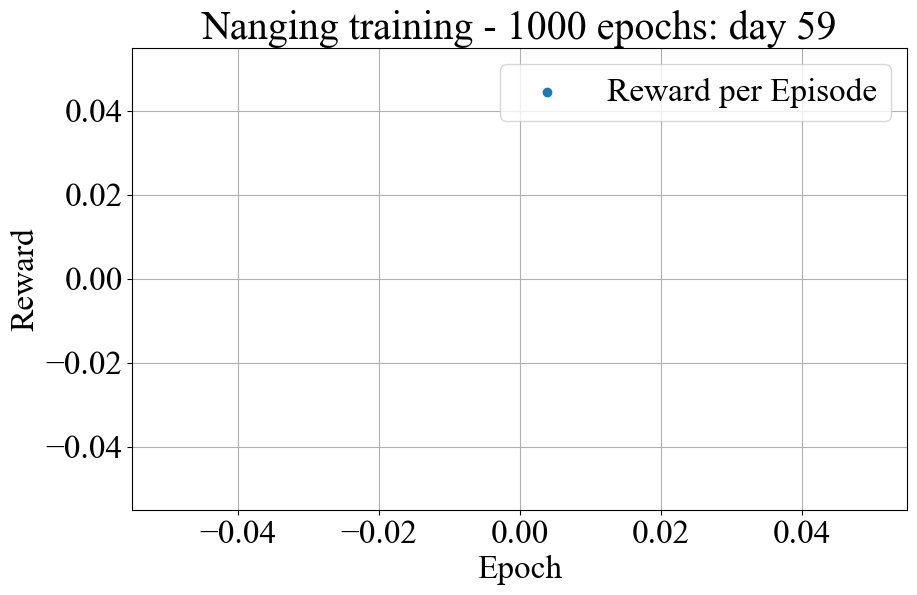

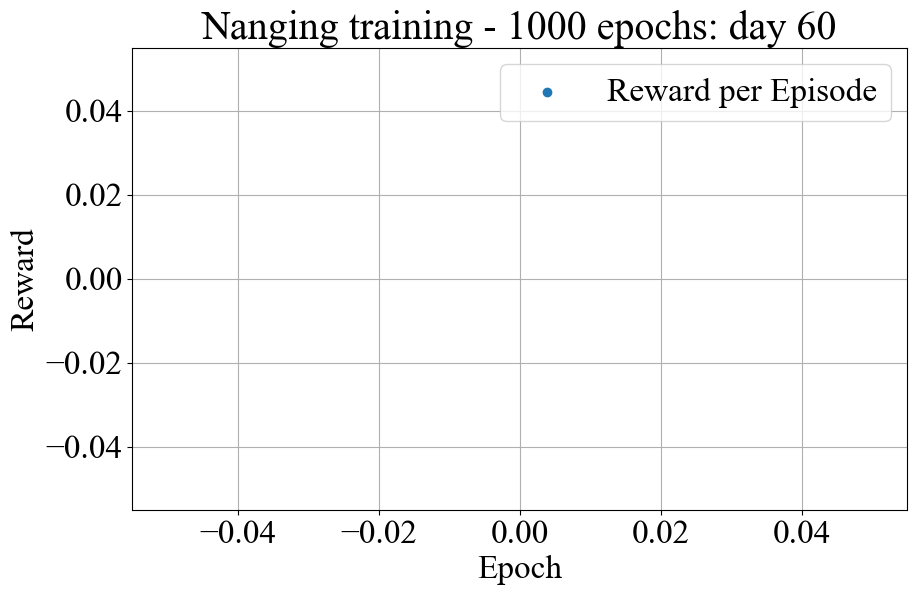

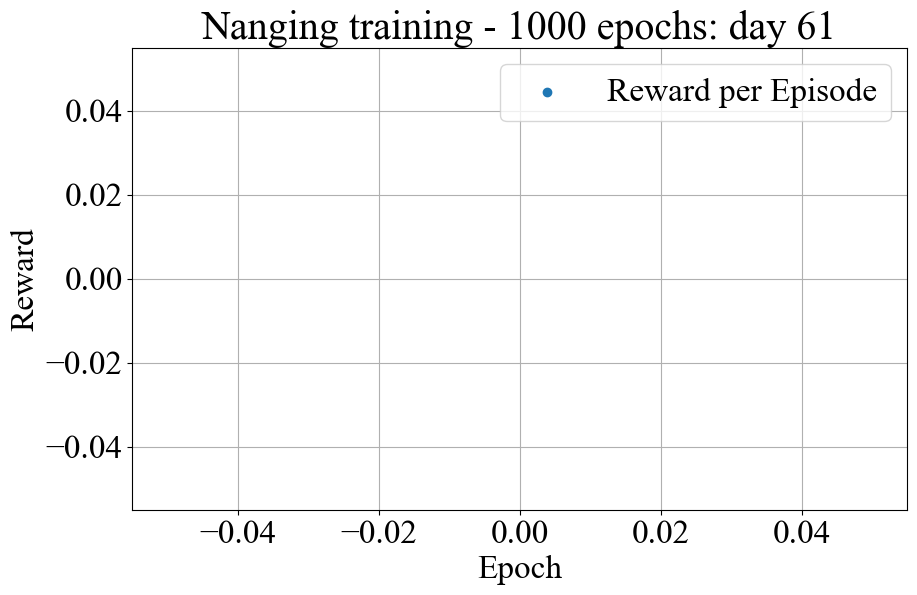

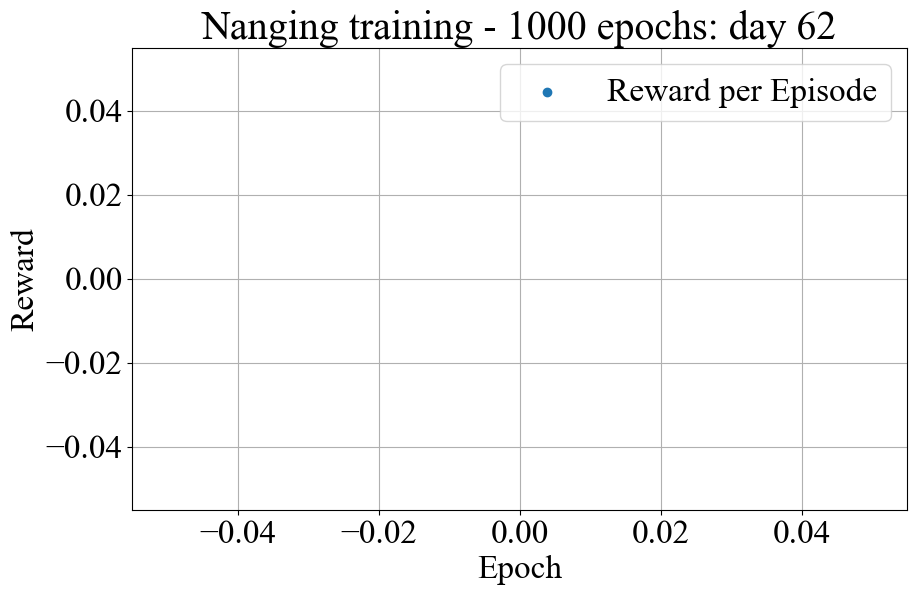

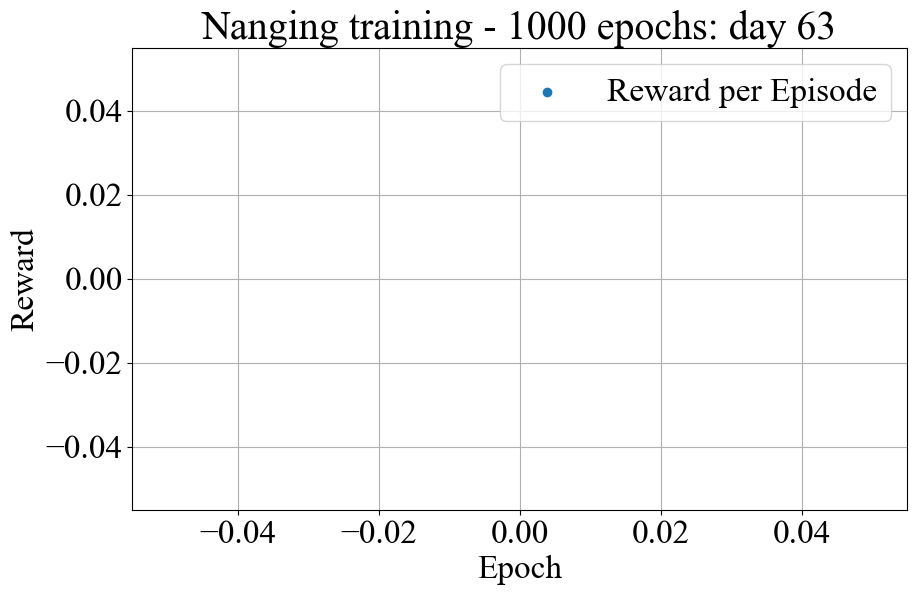

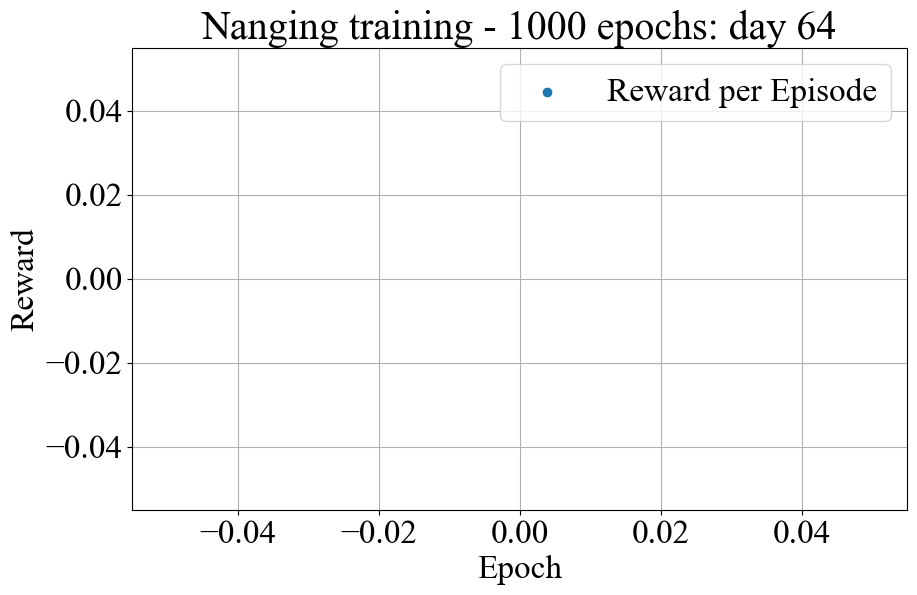

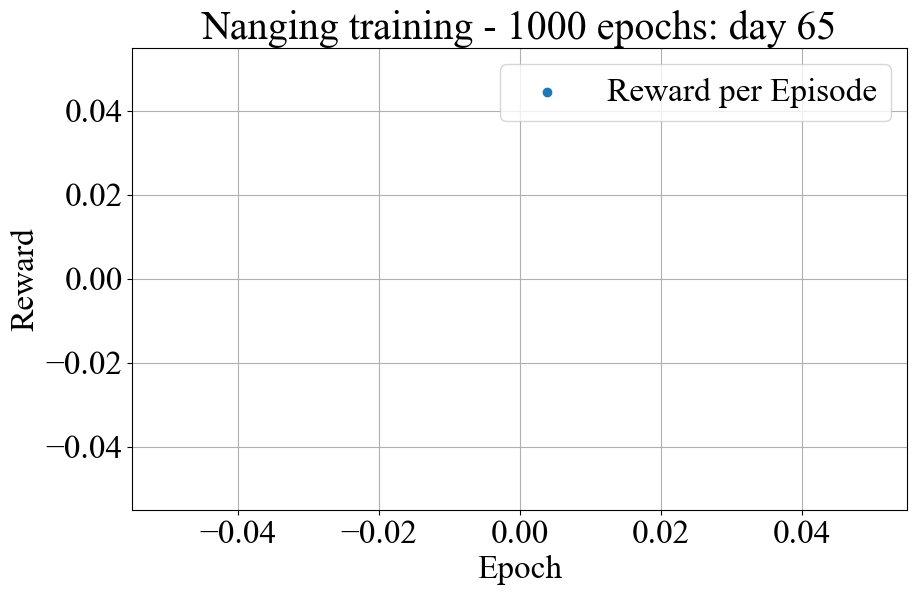

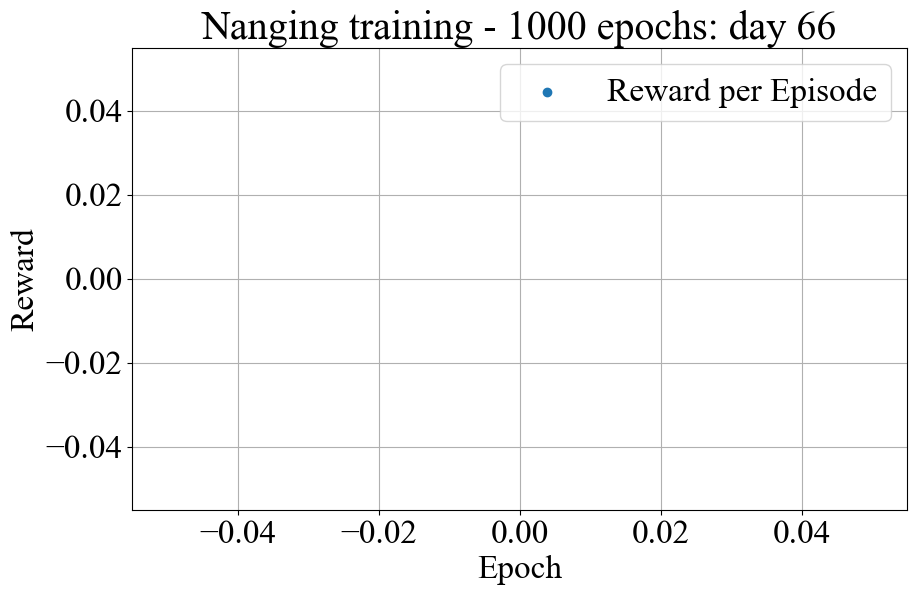

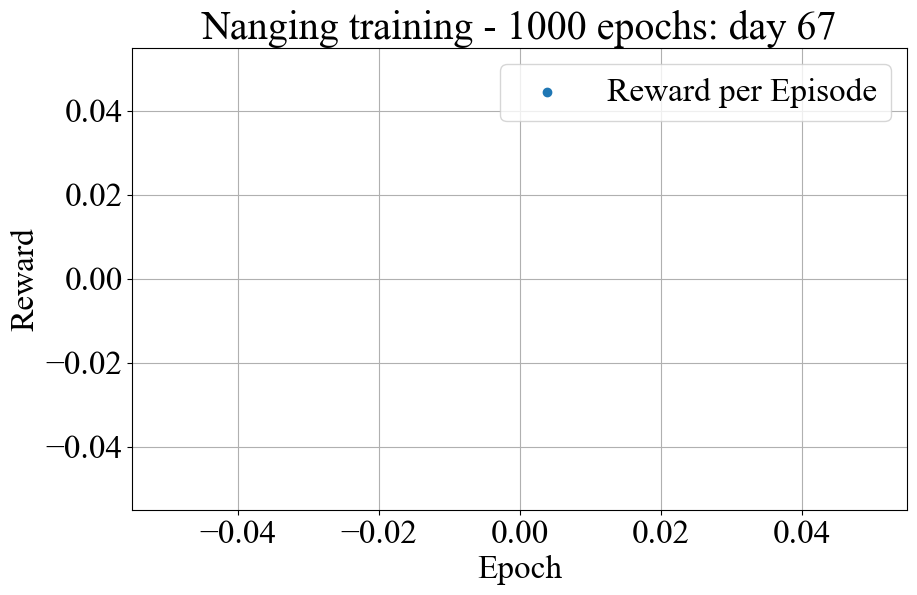

IndexError: list index out of range

In [178]:
plot_days_from_epochs_run(68, 1000,training_total_reward_list, "Nanging training - 1000 epochs")

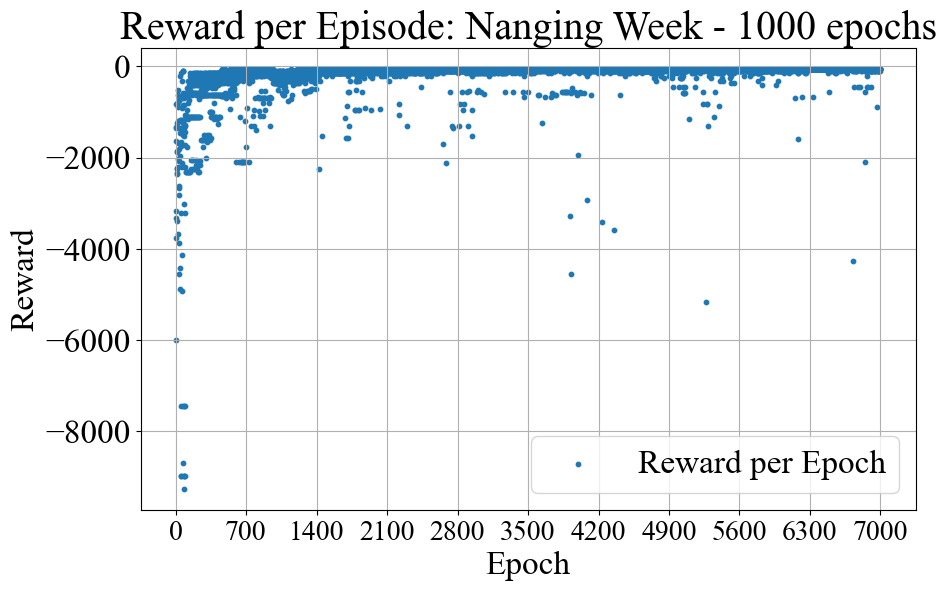

In [120]:
plot_epochs_reward(1000, training_total_reward_list, "Nanging Week - 1000 epochs")


## 8. Calculate policy by final model after training on all data

In [121]:
best_policy_final_model, next_in_temp_list_final_model, AC_Status_List_final_model, W_Status_List_final_model, best_policy_reward_list_final_model = create_policy_from_model(nanging_data_week, 7, Q_network, num_actions, num_features)

[0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0]
[29.7, 29.59164111763239, 29.371042688190936, 29.29376123547554, 29.244282887130975, 29.022986785322427, 28.7867736376822, 26.146903232485055, 25.003279880434274, 25.07332746759057, 25.193569124490022, 25.35937076881528, 25.497487754374742, 25.631215096265077, 25.676953357458114, 25.899559345841407, 25.918806462362408, 26.10833574719727, 26.168027194961905, 26.112773570045828, 26.203593584522604, 26.18756265081465, 26.192228774819522, 26.16527368435636]
[0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[28.9, 28.684399569034575, 28.50103864967823, 28.380494908988474, 28.29739218354225, 28.19477899521589, 28.173810362443326, 25.89767301045358, 25.94179093800485, 25.945737910550086, 26.246241939347236, 26.229839840065686, 26.443230205308645, 26.55890277130529, 26.90128079159185, 26.991180473100393, 27.150585019122808, 27.305927106272428, 27.289455303084104, 27.101573520433156, 27.008531869482

## 8.1 Calculate Rule Based Policy for comparison

In [38]:
highest_limit = 27
lowest_limit = 17
cool_outside = 20
warm_outside = 25

def rule_based_policy(state):
    indoor_temp = state['Indoor_Temp']
    outdoor_temp = state['Outdoor_Temp']
    if indoor_temp > highest_limit:
        if outdoor_temp < cool_outside:
            return 12 # Open window
        else:
            return 1 # turn on AC on 20 degrees
        
    elif indoor_temp < lowest_limit:
        if outdoor_temp > warm_outside:
            return 12 # open window
        else:
            return 11 # turn on AC on 30 degrees
        
    else: # room temperature is OK
        return 0

# Creates a basic rule based policy, for data with full 24 hours 
def create_rule_based_policy(data, num_days, num_features):
    policy = []
    next_in_temp_list = []
    AC_Status_List=[]
    W_Status_List=[]
    reward_list = []
    for i in range(num_days):
        data_test,xgboost_test = choose_data(i*24,data)    
        data_pre_test = data_test
        xgboost_pre_test = xgboost_test
        total_policy_reward = 0
        for step in range(0,6):
            if step ==0:
                temp_original = data_pre_test.iloc[step]['Indoor_Temp']
                next_in_temp_list.append(temp_original)
            policy.append(0)
            AC_Status_List.append(0)
            W_Status_List.append(0)
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_in_temp_list.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        state = data_pre_test.iloc[6, :num_features]
        for step in range(6,18):
            action = rule_based_policy(state)
            Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
            policy.append(action)
            AC_Status_List.append(AC_Status)
            W_Status_List.append(Window_Status)
            xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
            xgboost_pre_test.at[step,'AC_Status'] = AC_Status
            xgboost_pre_test.at[step,'Window_Status'] = Window_Status
            xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
            xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
            if CLast_Time > 0:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
            else:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
            if WLast_Time > 0:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
            else:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_in_temp_list.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_state = data_pre_test.iloc[step+1, :num_features]
            reward = calculate_reward(state,step, action, next_state.values)
            total_policy_reward += reward      
            state = next_state
        for step in range(18,23):
            policy.append(0)
            AC_Status_List.append(0)
            W_Status_List.append(0)
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_in_temp_list.append(next_in_temp)
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        policy.append(0)  
        AC_Status_List.append(0)
        W_Status_List.append(0)
        reward_list.append(total_policy_reward)  

        print(policy[(i)*24:(i+1)*24])
        print(next_in_temp_list[(i)*24:(i+1)*24])
    return policy, next_in_temp_list, AC_Status_List, W_Status_List, reward_list

In [41]:
rb_policy, rb_next_in_temp_list, rb_AC_Status_List, rb_W_Status_List, rb_reward_list = create_rule_based_policy(data=nanging_data_week, num_days=7, num_features=num_features)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[29.7, 29.59164111763239, 29.371042688190936, 29.29376123547554, 29.244282887130975, 29.022986785322427, 28.7867736376822, 23.195633367449044, 23.326347694545984, 23.43239905759692, 23.62821968719363, 23.839725904911756, 24.039550372213125, 24.2083068870008, 24.257536117732524, 24.536323879659175, 24.586932976543903, 24.78882264047861, 24.952895094454288, 24.88776123970747, 24.980085265636443, 24.984378193784504, 25.0023923211731, 24.994116703327744]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[28.9, 28.684399569034575, 28.50103864967823, 28.380494908988474, 28.29739218354225, 28.19477899521589, 28.173810362443326, 23.09900987111032, 23.215269222483037, 23.238083937764166, 23.777686396241187, 24.342557170987128, 24.78362695276737, 25.004285851120947, 25.37965247929096, 25.53944812119007, 25.71561478972435, 25.90916902720928, 25.958219477534293, 25.8325762540102, 25.803636394068597, 25.

In [47]:
import os 
import pickle

def save_rule_based_results(dir_name, policy, next_in_temp_list, AC_Status_List, W_Status_List, reward_list, description=None):    
    # Create the directory if it does not exist
    if os.path.exists(dir_name):
        raise Exception("This directory already exist. To avoid overriding it, remove it manually only if you are sure")
    
    os.makedirs(dir_name)

    # Define the file paths
    reward_list_path = os.path.join(dir_name, "rb_policy_reward_list.pkl")
    policy_path = os.path.join(dir_name, "rb_policy.pkl")
    next_in_temp_list_path = os.path.join(dir_name, "rb_next_in_temp_list.pkl")
    AC_Status_List_path = os.path.join(dir_name, "rb_AC_Status_List.pkl")
    W_Status_List_path = os.path.join(dir_name, "rb_W_Status_List.pkl")
    reward_list_path = os.path.join(dir_name, "rb_reward_list.pkl")

    with open(policy_path, 'wb') as best_policy_file:
        pickle.dump(policy, best_policy_file)
    
    with open(next_in_temp_list_path, 'wb') as next_in_temp_file:
        pickle.dump(next_in_temp_list, next_in_temp_file)

    with open(AC_Status_List_path, 'wb') as AC_file:
        pickle.dump(AC_Status_List, AC_file)

    with open(W_Status_List_path, 'wb') as W_file:
        pickle.dump(W_Status_List, W_file)

    with open(reward_list_path, 'wb') as best_reward_file:
        pickle.dump(reward_list, best_reward_file)

    if description is not None:
        description_path = os.path.join(dir_name, "description.txt")
        with open(description_path, 'w') as desc_file:
            desc_file.write(description)       

    print(f"Results saved in directory: {dir_name}")     

In [48]:
dir_name = "nanjing_week_rule_based"
description = "rule based policy calculated for nanjing week data"

save_rule_based_results(dir_name, rb_policy, rb_next_in_temp_list, rb_AC_Status_List, rb_W_Status_List, rb_reward_list, description)

Results saved in directory: nanjing_week_rule_based


## 9 Visualization


In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, dates
from datetime import datetime, timedelta

def plot_result_policy(data_week, ac_status_list, window_status_list, next_in_temp_list, city_name,  policy_name, start_date_str, end_date_str):
    rc('font', family='Times New Roman', size=24)

    standard = 'ASHRAE'
    coordinates_dict = {'ASHRAE': [[17.4, 18.4, 23.4, 24.4], [23.6, 24.6, 29.6, 30.6], [10, 30]]}
    L11, L12, U12, U11 = coordinates_dict[standard][0]
    L21, L22, U22, U21 = coordinates_dict[standard][1]
    T1, T2 = coordinates_dict[standard][2]

    data_or_ = data_week
    data_or = data_or_
    OutT = data_or['Outdoor_Temp']
    data_or['Date_Time'] = pd.to_datetime(data_or['Date_Time'])
    data_or = data_or.sort_values(by='Date_Time')
    data_or.set_index('Date_Time', inplace=True)
    
    date_format = "%Y-%m-%d" 
    start_date = datetime.strptime(start_date_str, date_format)
    end_date = datetime.strptime(end_date_str, date_format)
    UP = []
    LO = []
    for temp in OutT:
        if temp <= T1:
            L1, L2, U2, U1 = L11, L12, U12, U11
        elif temp >= T2:
            L1, L2, U2, U1 = L21, L22, U22, U21
        else:
            increase = (temp - T1) * (L21 - L11) / (T2 - T1)
            L1, L2, U2, U1 = L11 + increase, L12 + increase, U12 + increase, U11 + increase
        UP.append(U1-1)
        LO.append(L1+1)


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), dpi=300, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

    # Plot Temperature Change Line Chart
    # 绘制温度变化折线图
    ax1.plot(data_or.index, data_or['Outdoor_Temp'], label='Outdoor_Temp', color='gray', alpha=0.75, linewidth=3)
    ax1.plot(data_or.index, data_or['Indoor_Temp'], linestyle='-', linewidth=4, label='Human-controlled', color='Orange', alpha=0.75)
    ax1.fill_between(data_or.index, LO, UP, color='grey', alpha=0.3, label='Comfort Zone', interpolate=True)
    ax1.plot(data_or.index, next_in_temp_list, linestyle='-', linewidth=4, label='RL-controlled', color='#C46DC4', alpha=0.75)

    date_format = dates.DateFormatter('%m-%d')
    day_locator = dates.DayLocator(interval=1)

    ax1.xaxis.set_major_formatter(date_format)
    ax1.xaxis.set_major_locator(day_locator)
    ax1.tick_params(axis='x', rotation=0)
    ax1.set_title(f'{city_name} week: {policy_name}',y=1.02)
    ax1.set_ylabel('Temperature [°C]')
    ax1.grid(True, which='major', axis='x')  # Add vertical grid lines at major ticks only
    ax1.set_ylim(21, 34)
    ax1.set_xlim(start_date, end_date)
    ax1.legend(loc='upper left', fontsize='10')

    # Adding shaded areas for 6 am to 6 pm
    current_date = start_date
    while current_date <= end_date:
        start_time = current_date + timedelta(hours=6)
        end_time = current_date + timedelta(hours=19)
        ax1.axvspan(start_time, end_time, color='#C4A484', alpha=0.3)
        ax2.axvspan(start_time, end_time, color='#C4A484', alpha=0.5)
        ax3.axvspan(start_time, end_time, color='#C4A484', alpha=0.5)
        current_date += timedelta(days=1)

    # Plot Air Conditioning Status Line Chart
    # 绘制空调状态折线图
    ax2.step(data_or.index, data_or['AC_Status'], where='post', linestyle='-', linewidth=4, label='Human', color='Orange', alpha=1)
    ax2.step(data_or.index, ac_status_list, where='post', linestyle='-', linewidth=4, label='RL Controlled', color='#C46DC4', alpha=0.75)
    # ax2.plot(data_or.index, AC_status_empty_policy, linestyle='-', linewidth=4, label='Empty Policy', color='#2C9C91', alpha=0.75)
    ax2.xaxis.set_major_formatter(date_format)
    ax2.xaxis.set_major_locator(day_locator)
    ax2.tick_params(axis='x', rotation=0)
    ax2.set_ylabel('AC Status')
    ax2.grid(True)
    ax2.set_ylim(-0.5, 1.5)
    ax2.set_xlim(start_date, end_date)

    ax2.legend(loc='upper left', fontsize='10')


    # Plot Window Status Line Chart
    ax3.step(data_or.index, data_or['Window_Status'], where='post', linestyle='-', linewidth=4, label='Human', color='Orange', alpha=1)
    ax3.step(data_or.index, window_status_list, where='post', linestyle='-', linewidth=4, label='RL Controlled', color='#C46DC4', alpha=0.75)
    # ax3.plot(data_or.index, W_Status_empty_policy, linestyle='-', linewidth=4, label='Empty Policy', color='#2C9C91', alpha=0.75)
    ax3.xaxis.set_major_formatter(date_format)
    ax3.xaxis.set_major_locator(day_locator)
    ax3.tick_params(axis='x', rotation=0)
    ax3.set_ylabel('Window Status')
    ax3.grid(True)
    ax3.set_ylim(-0.5, 1.5)
    ax3.set_xlim(start_date, end_date)

    ax3.legend(loc='upper left', fontsize='10')


    plt.tight_layout()
    plt.show()

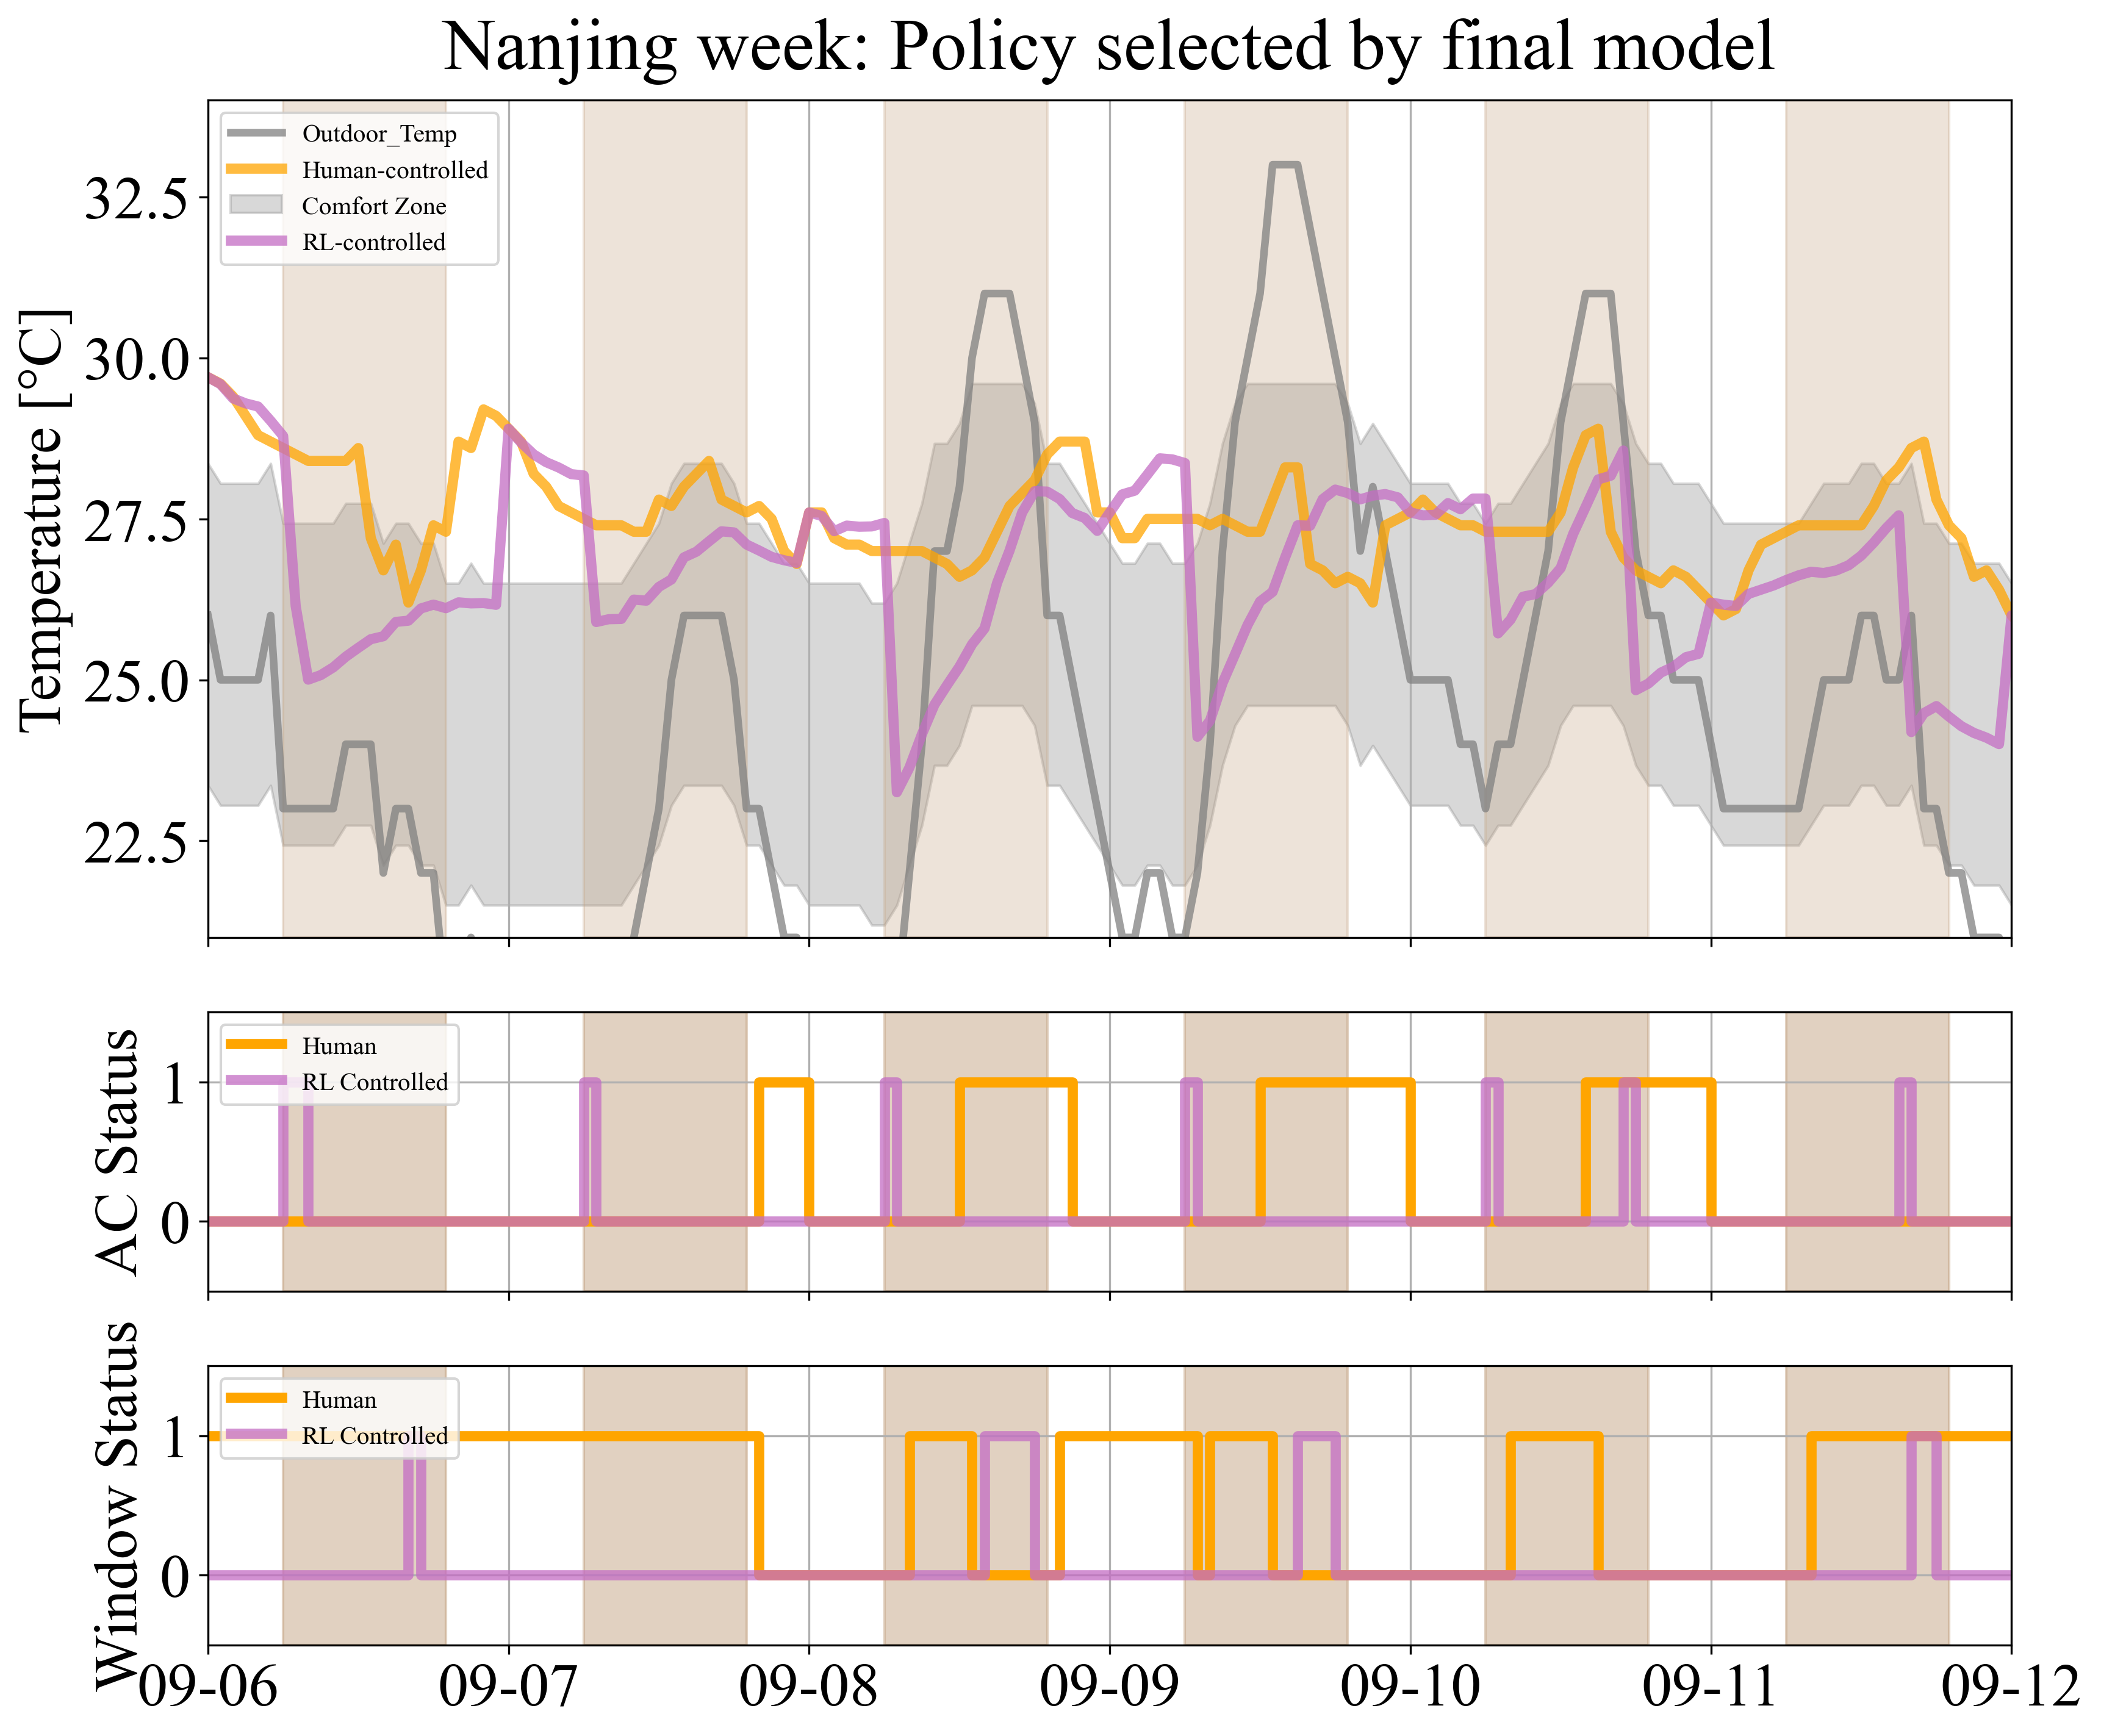

In [179]:
plot_result_policy(nanging_data_week, AC_Status_List_final_model, W_Status_List_final_model, next_in_temp_list_final_model, "Nanjing", "Policy selected by final model", *city_dates_mapping["Nanjing"])

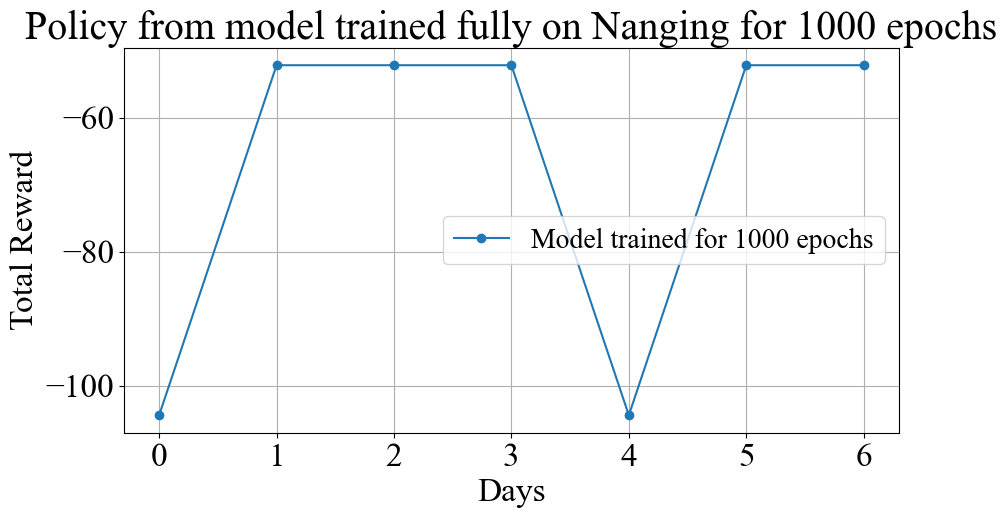

In [117]:

days = list(range(0, 7)) 

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(days, best_policy_reward_list_final_model, 'o-', label='Model trained for 1000 epochs')

# Adding titles and labels
plt.title(f"Policy from model trained fully on Nanging for 1000 epochs")
plt.xlabel("Days")
plt.ylabel("Total Reward")

# Adding a legend
plt.legend(fontsize="small")

# Display the plot
plt.grid(True)
plt.xticks(days)  # Ensure all days are displayed on x-axis
plt.show()

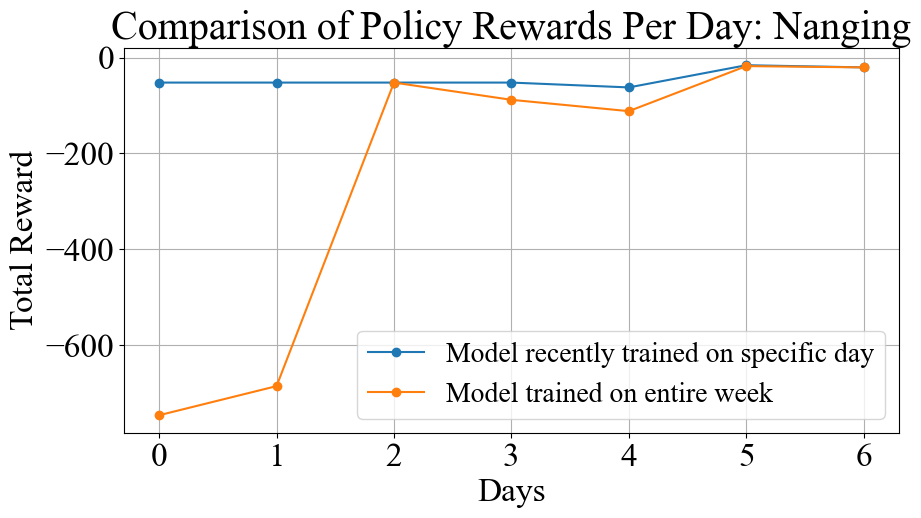

In [58]:
# Days of the week represented as numbers

def plot_comparison_of_policies_total_reward_per_day(policy_1_reward_list, policy_2_reward_list, city):
    days = list(range(0, 7)) 

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(days, policy_1_reward_list, 'o-', label='Model recently trained on specific day')
    plt.plot(days, policy_2_reward_list, 'o-', label='Model trained on entire week')

    # Adding titles and labels
    plt.title(f"Comparison of Policy Rewards Per Day: {city}")
    plt.xlabel("Days")
    plt.ylabel("Total Reward")

    # Adding a legend
    plt.legend(fontsize="small")

    # Display the plot
    plt.grid(True)
    plt.xticks(days)  # Ensure all days are displayed on x-axis
    plt.show()

plot_comparison_of_policies_total_reward_per_day(best_policy_total_reward_list, best_policy_reward_list_final_model, "Nanging")